In [31]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [32]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

In [40]:
#sorting ascending order since the image features are in ascending order
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data=data.sort_values(by='asin',ascending=True)
data.head()

asin           brand  color  \
110006  0000000060           Jofit  White   
77667   6042589113  Dress on Trend  White   
158935  6342521018           Crazy  Beige   
134717  B00029I0Z6           Roper  Red 2   
113017  B0006LTFTK        Ideology   Noir   

                                         medium_image_url  product_type_name  \
110006  https://images-na.ssl-images-amazon.com/images...  BUILDING_MATERIAL   
77667   https://images-na.ssl-images-amazon.com/images...              SHIRT   
158935  https://images-na.ssl-images-amazon.com/images...              SHIRT   
134717  https://images-na.ssl-images-amazon.com/images...              SHIRT   
113017  https://images-na.ssl-images-amazon.com/images...              PANTS   

                                                    title formatted_price  
110006       jofit womens jo tech polo white extra large           $25.99  
77667   dress trend womens lion chain print baggy over...          $16.00  
158935  crazy womens floral sleeveless vintage crochet...           $9.99  
134717  roper womens ls stars stripes pieced flag red ...          $48.78  
113017  ideology womens graphic training leggings noir...          $49.50

In [34]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [35]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [36]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [37]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [38]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

#type_vectorizer = CountVectorizer()
#type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, color_features)).tocsr()

In [39]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
#data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

In [41]:
data.iloc[12566]

asin                                                        B072277HVB
brand                                                     Foxcroft NYC
color                                                            White
medium_image_url     https://images-na.ssl-images-amazon.com/images...
product_type_name                                                SHIRT
title                foxcroft nyc womens pinpoint oxford shirt noni...
formatted_price                                                 $47.99
Name: 177930, dtype: object

In [13]:
data.shape

(16042, 7)

In [56]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [57]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [58]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [59]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

## Weights to Brand, Color, idf and image Features 

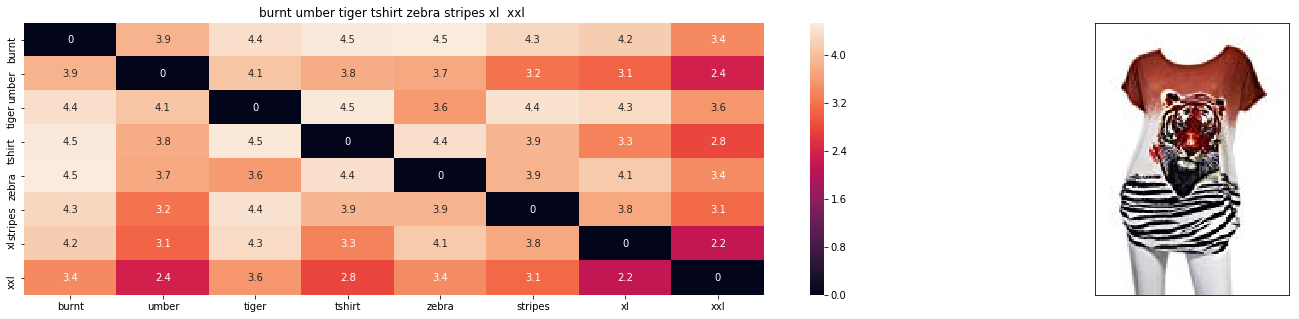

ASIN : B00JXQB5FQ
Brand : Si Row
Product Title : burnt umber tiger tshirt zebra stripes xl  xxl 
euclidean distance from the given image : 0.003399551774446781


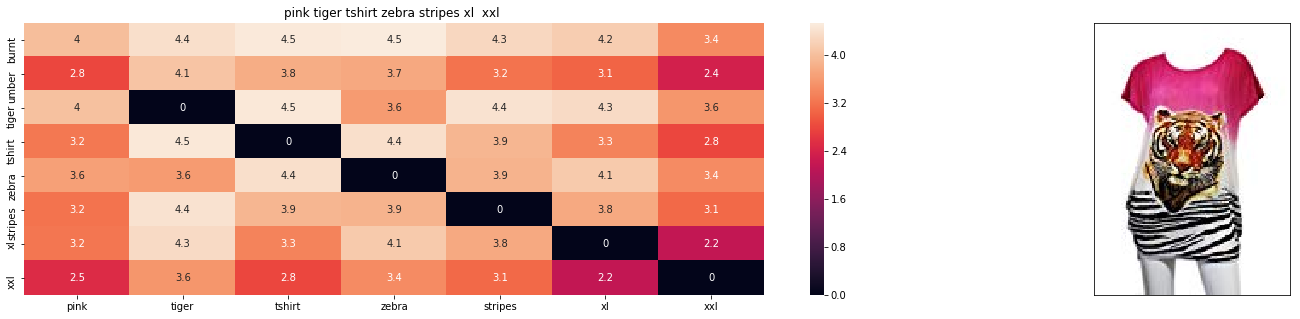

ASIN : B00JXQASS6
Brand : Si Row
Product Title : pink tiger tshirt zebra stripes xl  xxl 
euclidean distance from the given image : 2.553563140573962


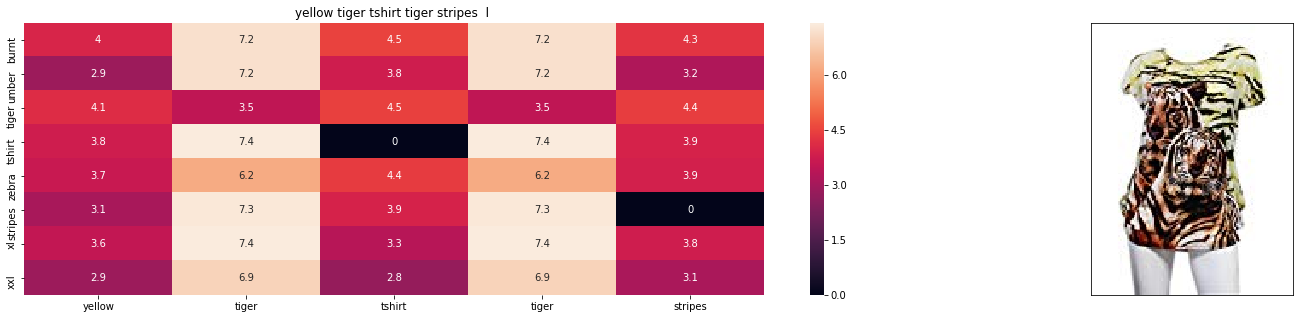

ASIN : B00JXQCUIC
Brand : Si Row
Product Title : yellow tiger tshirt tiger stripes  l 
euclidean distance from the given image : 3.4862366989671116


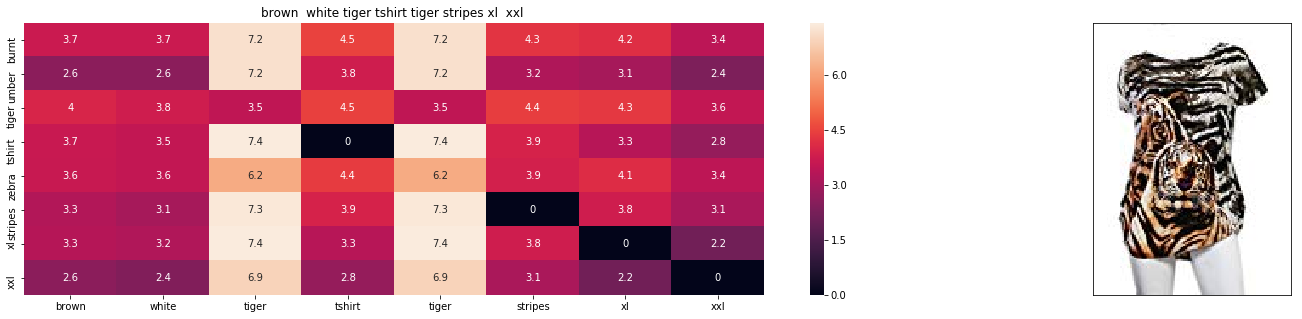

ASIN : B00JXQCWTO
Brand : Si Row
Product Title : brown  white tiger tshirt tiger stripes xl  xxl 
euclidean distance from the given image : 3.5730529313108454


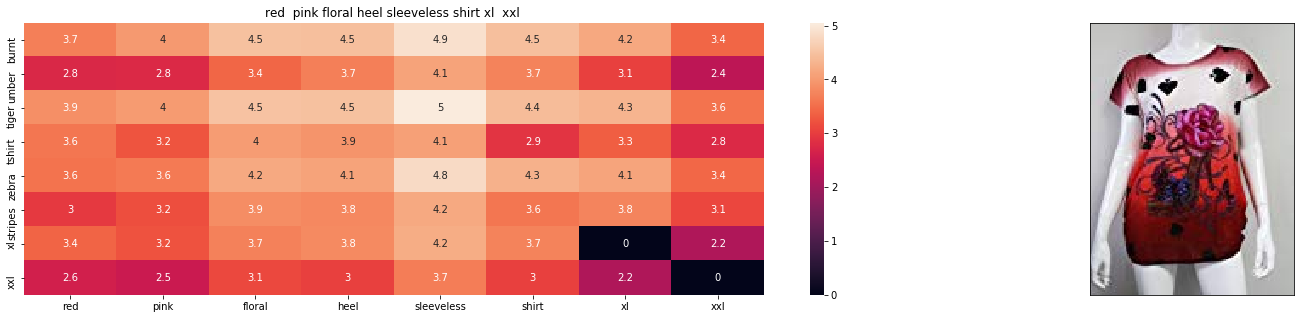

ASIN : B00JV63QQE
Brand : Si Row
Product Title : red  pink floral heel sleeveless shirt xl  xxl 
euclidean distance from the given image : 4.080597233080763


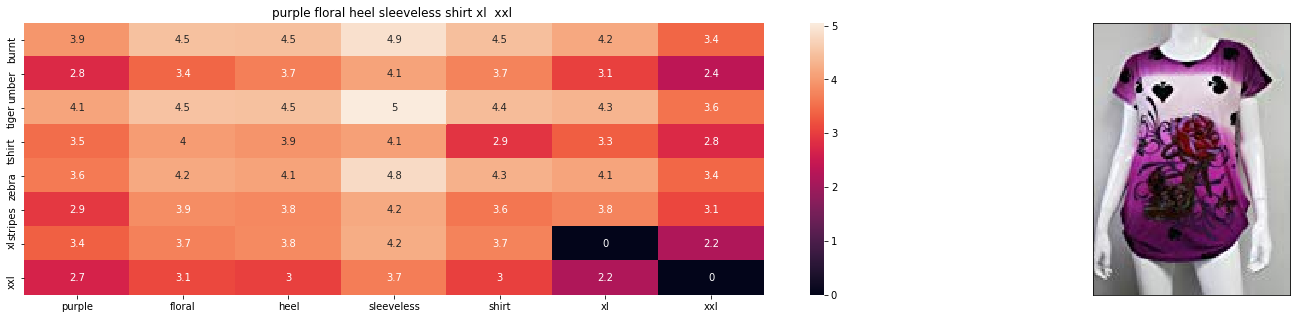

ASIN : B00JV63VC8
Brand : Si Row
Product Title : purple floral heel sleeveless shirt xl  xxl 
euclidean distance from the given image : 4.137469039077072


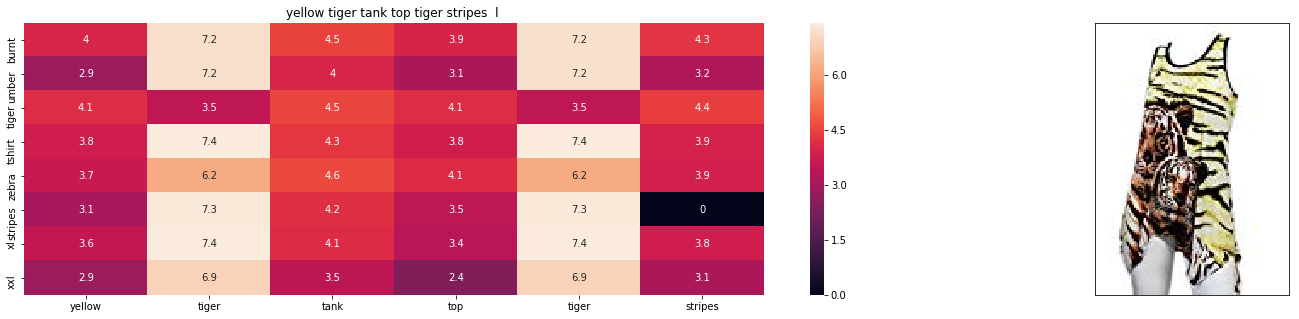

ASIN : B00JXQAUWA
Brand : Si Row
Product Title : yellow tiger tank top tiger stripes  l 
euclidean distance from the given image : 4.212823637461123


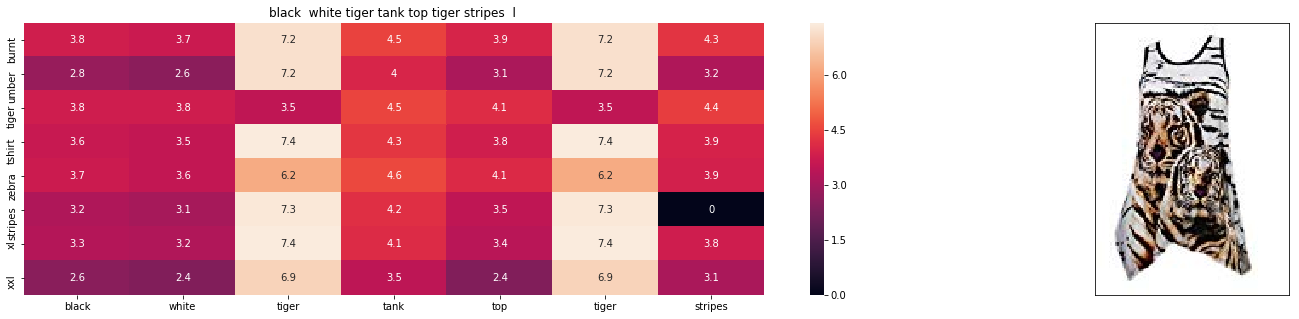

ASIN : B00JXQAO94
Brand : Si Row
Product Title : black  white tiger tank top tiger stripes  l 
euclidean distance from the given image : 4.233545124094349


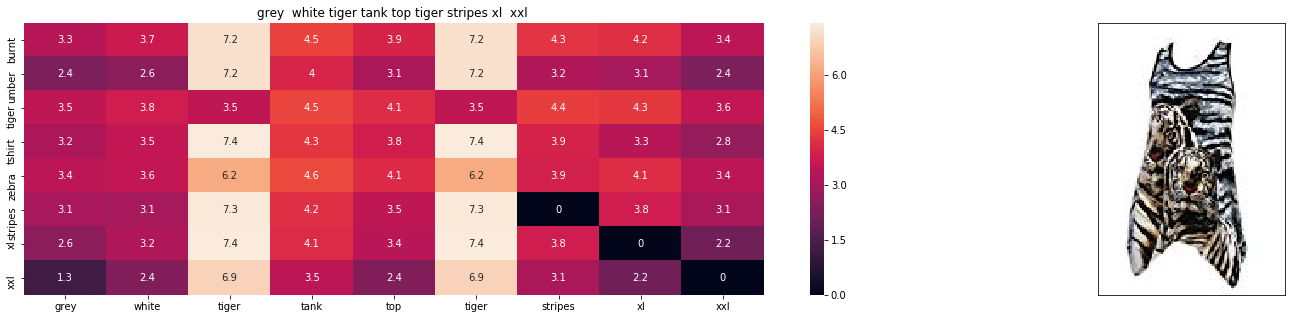

ASIN : B00JXQAFZ2
Brand : Si Row
Product Title : grey  white tiger tank top tiger stripes xl  xxl 
euclidean distance from the given image : 4.268669304508718


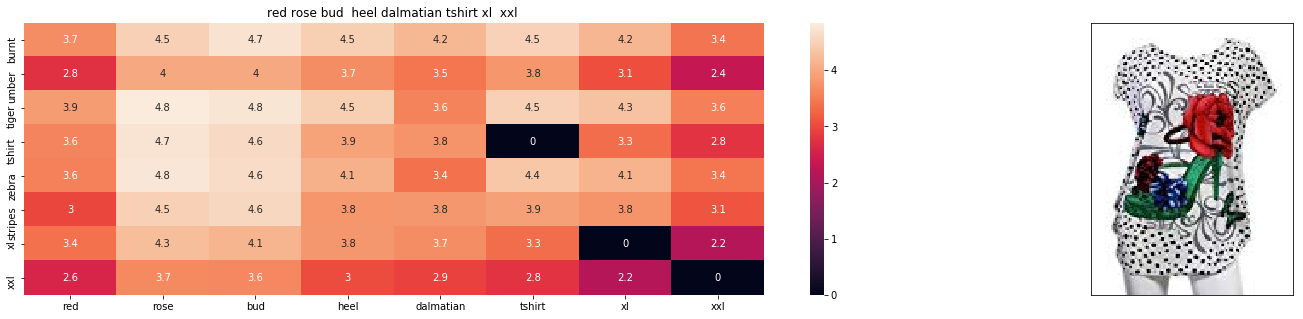

ASIN : B00JXQABB0
Brand : Si Row
Product Title : red rose bud  heel dalmatian tshirt xl  xxl 
euclidean distance from the given image : 4.292733622343184


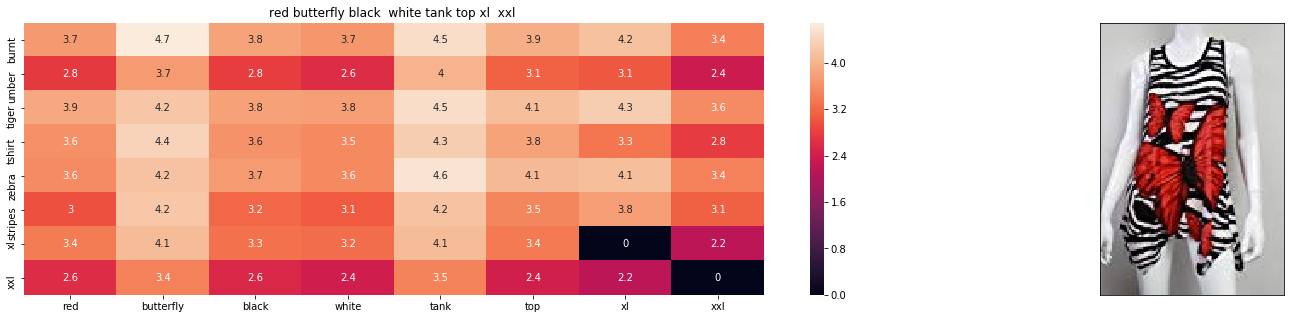

ASIN : B00JV63CW2
Brand : Si Row
Product Title : red butterfly black  white tank top xl  xxl 
euclidean distance from the given image : 4.311069797778028


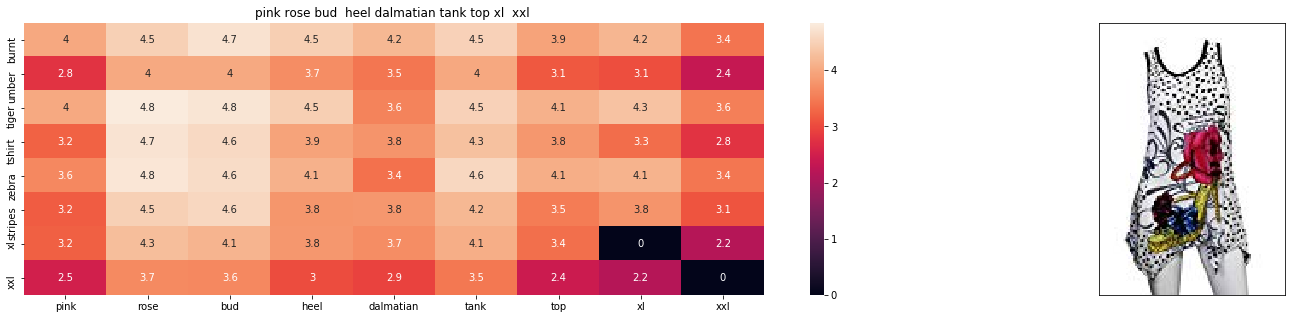

ASIN : B00JXQAX2C
Brand : Si Row
Product Title : pink rose bud  heel dalmatian tank top xl  xxl 
euclidean distance from the given image : 4.327016165410545


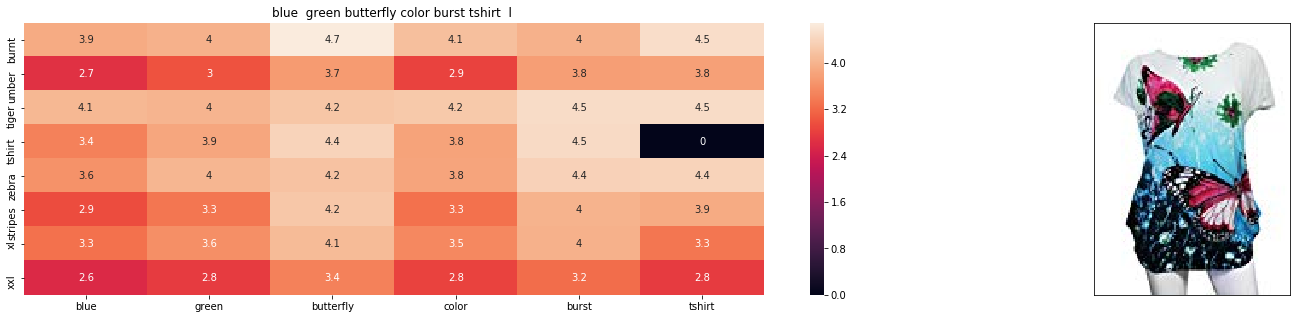

ASIN : B00JXQC0C8
Brand : Si Row
Product Title : blue  green butterfly color burst tshirt  l 
euclidean distance from the given image : 4.433806801984759


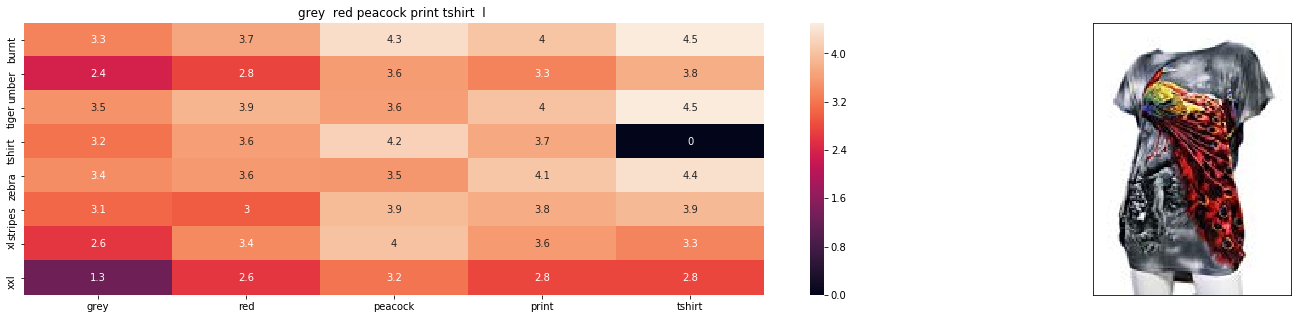

ASIN : B00JXQCFRS
Brand : Si Row
Product Title : grey  red peacock print tshirt  l 
euclidean distance from the given image : 4.438930478943358


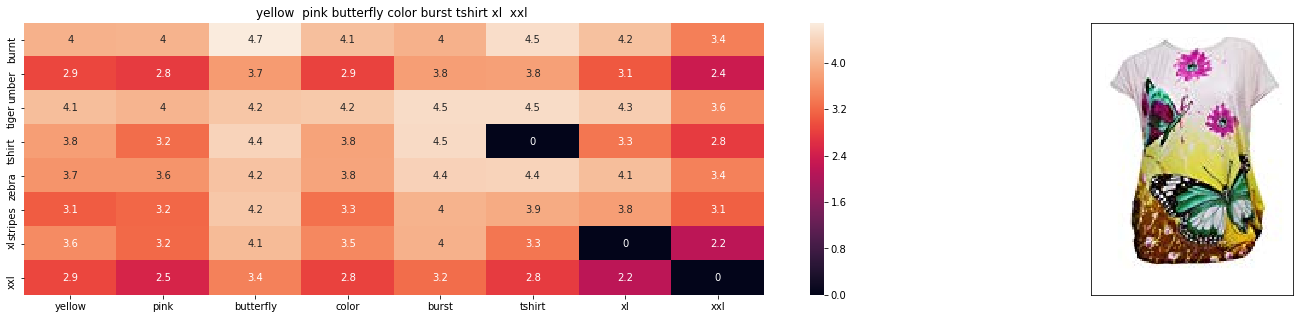

ASIN : B00JXQBBMI
Brand : Si Row
Product Title : yellow  pink butterfly color burst tshirt xl  xxl 
euclidean distance from the given image : 4.457841642832217


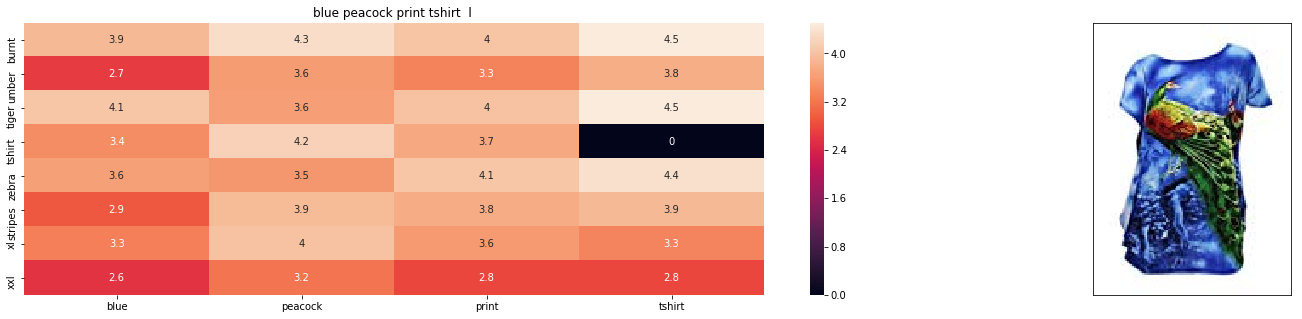

ASIN : B00JXQC8L6
Brand : Si Row
Product Title : blue peacock print tshirt  l 
euclidean distance from the given image : 5.037157415255594


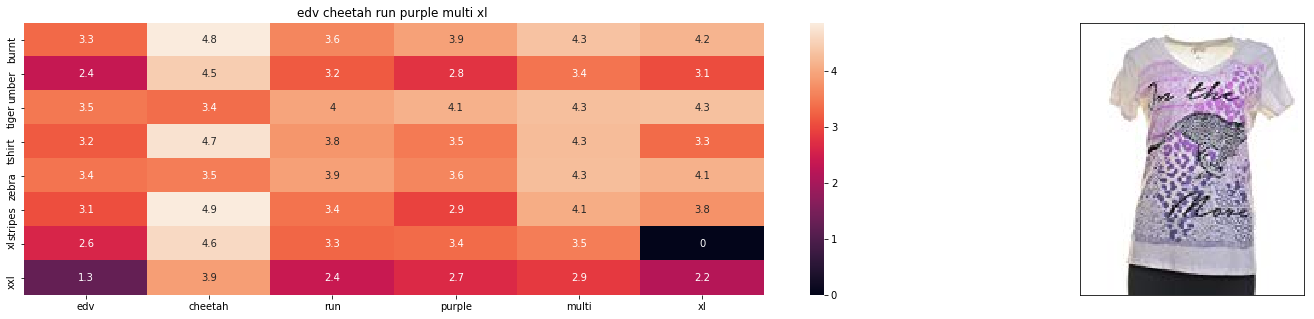

ASIN : B01CUPYBM0
Brand : Styleco
Product Title : edv cheetah run purple multi xl 
euclidean distance from the given image : 5.403483852353246


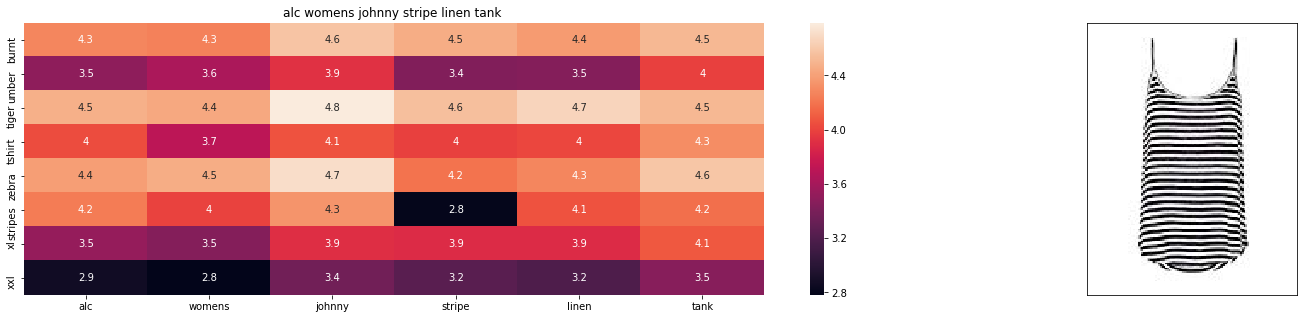

ASIN : B071CMN66J
Brand : A.L.C.
Product Title : alc womens johnny stripe linen tank 
euclidean distance from the given image : 5.433858948295338


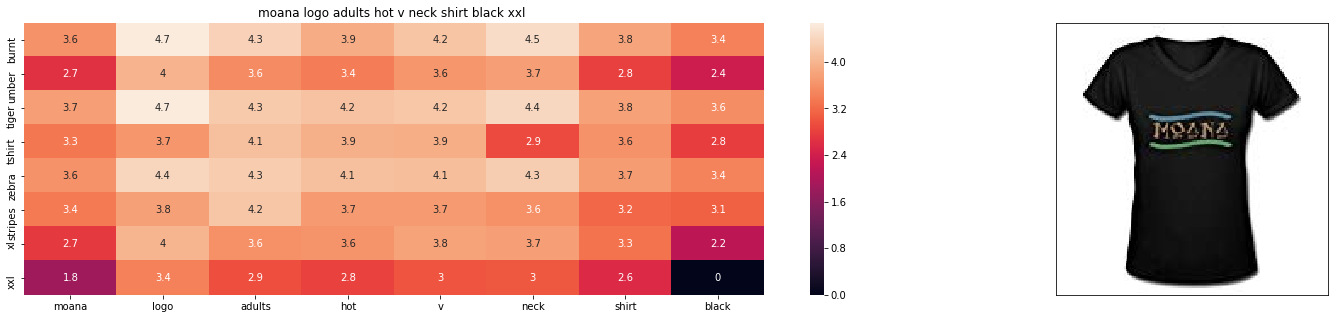

ASIN : B01LX6H43D
Brand : BOBOB
Product Title : moana logo adults hot v neck shirt black xxl 
euclidean distance from the given image : 5.441012133990525


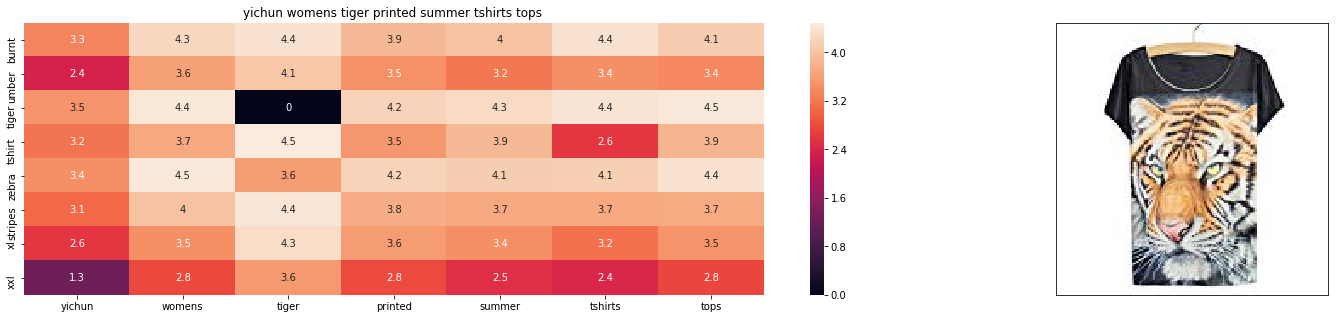

ASIN : B010NN9RXO
Brand : YICHUN
Product Title : yichun womens tiger printed summer tshirts tops 
euclidean distance from the given image : 5.445355196041201


In [61]:
#more weights to brand
def idf_model(doc_id,w1,w2,w3,w4,num_results):
    # doc_id: apparel's id in given corpus
    doc_id = asins.index(df_asins[doc_id])
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    idf_w2v_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    brand_features_dist = pairwise_distances(brand_features, brand_features[doc_id].reshape(1,-1))
    bottleneck_features_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    color_features_dist = pairwise_distances(color_features, color_features[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * brand_features_dist+w3*color_features_dist+w4*bottleneck_features_dist)/float(w1 + w2+w3+w4)
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(len(indices)):
        #get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
       
        print('ASIN :',data['asin'].loc[df_indices[i]])
        #display(Image(url=data['medium_image_url'].loc[df_indices[i]], embed=True))
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('Product Title :',data['title'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,1,10,1,1,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

Most of the shirts have same brand i.e si row

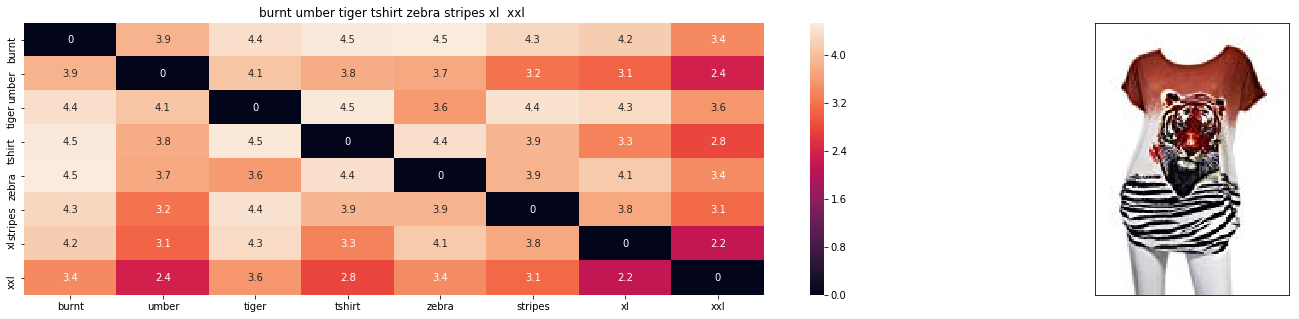

ASIN : B00JXQB5FQ
Brand : Si Row
Product Title : burnt umber tiger tshirt zebra stripes xl  xxl 
euclidean distance from the given image : 0.033995518317589395


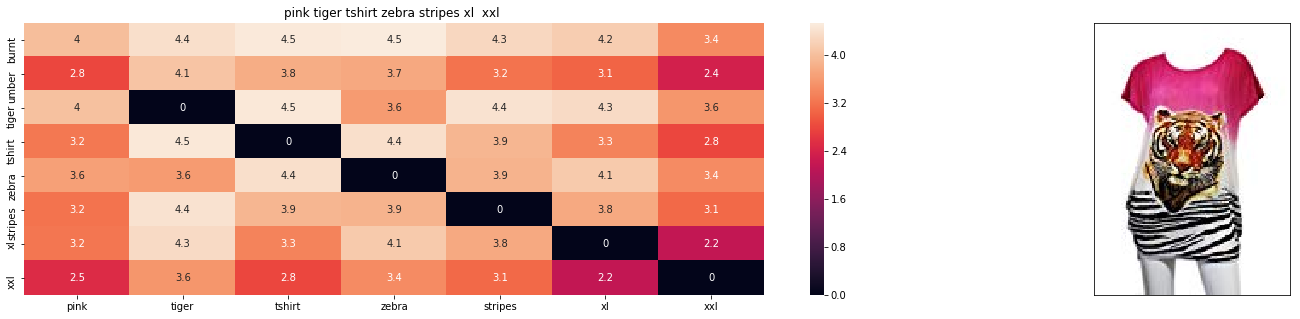

ASIN : B00JXQASS6
Brand : Si Row
Product Title : pink tiger tshirt zebra stripes xl  xxl 
euclidean distance from the given image : 23.35744720664217


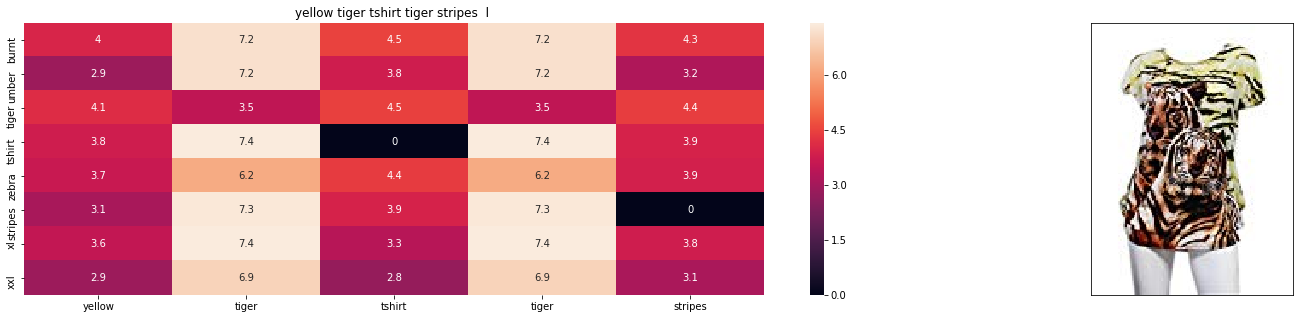

ASIN : B00JXQCUIC
Brand : Si Row
Product Title : yellow tiger tshirt tiger stripes  l 
euclidean distance from the given image : 32.05162149041468


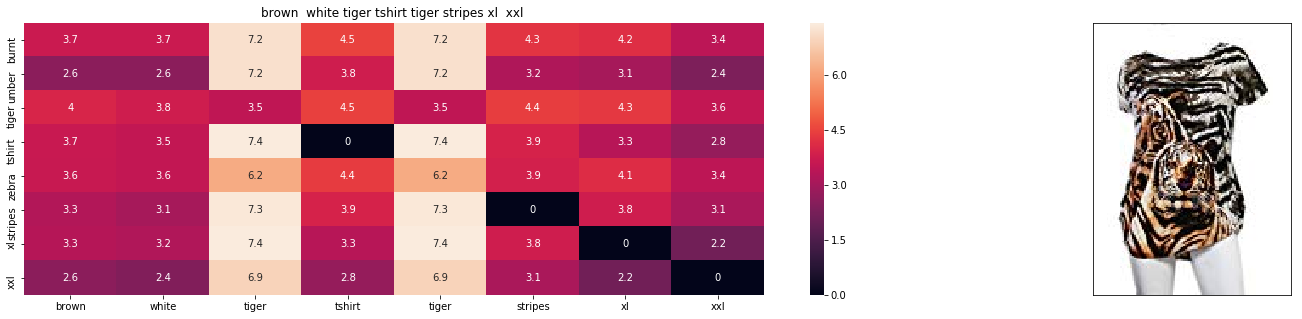

ASIN : B00JXQCWTO
Brand : Si Row
Product Title : brown  white tiger tshirt tiger stripes xl  xxl 
euclidean distance from the given image : 34.03472872195087


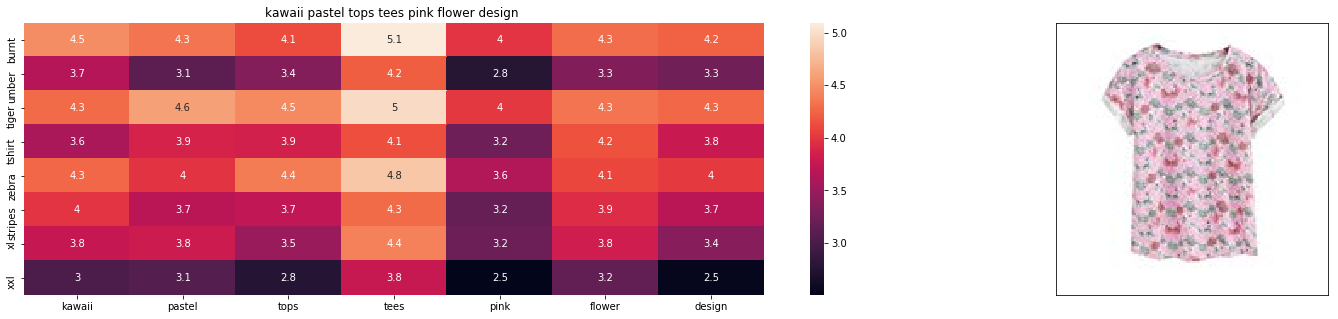

ASIN : B071FCWD97
Brand : Namnoi Clothing Store
Product Title : kawaii pastel tops tees pink flower design 
euclidean distance from the given image : 37.05124660700321


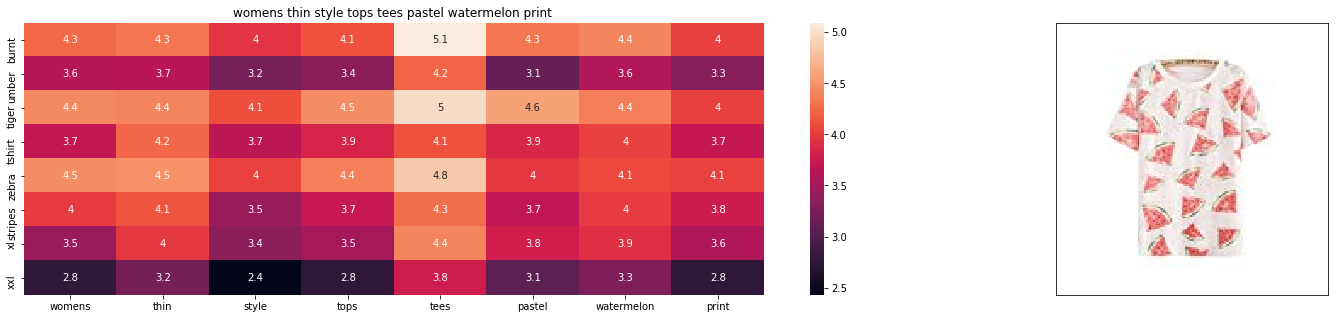

ASIN : B01JUNHBRM
Brand : Namnoi Clothing Store
Product Title : womens thin style tops tees pastel watermelon print 
euclidean distance from the given image : 37.31938597775768


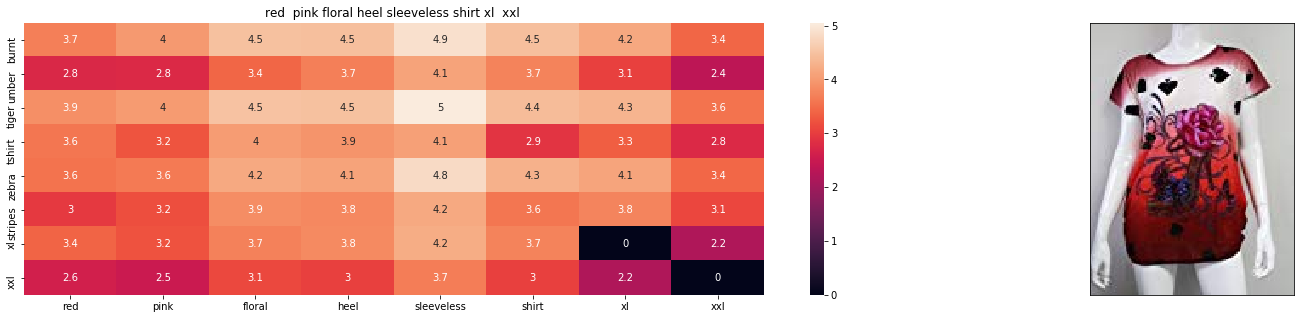

ASIN : B00JV63QQE
Brand : Si Row
Product Title : red  pink floral heel sleeveless shirt xl  xxl 
euclidean distance from the given image : 37.4286772079155


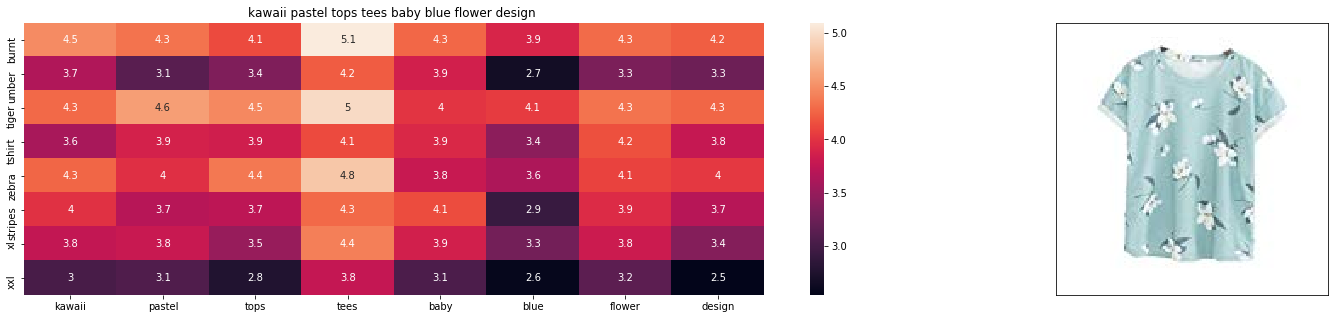

ASIN : B071SBCY9W
Brand : Namnoi Clothing Store
Product Title : kawaii pastel tops tees baby blue flower design 
euclidean distance from the given image : 37.46070114452451


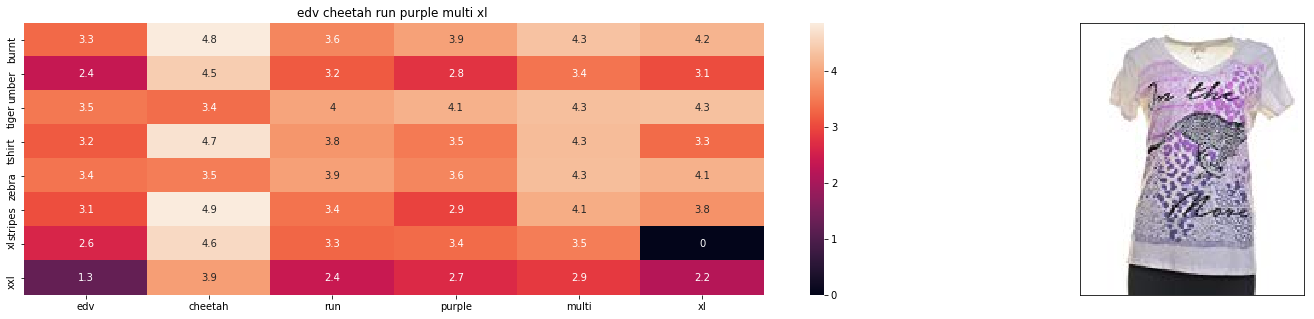

ASIN : B01CUPYBM0
Brand : Styleco
Product Title : edv cheetah run purple multi xl 
euclidean distance from the given image : 37.46730974073931


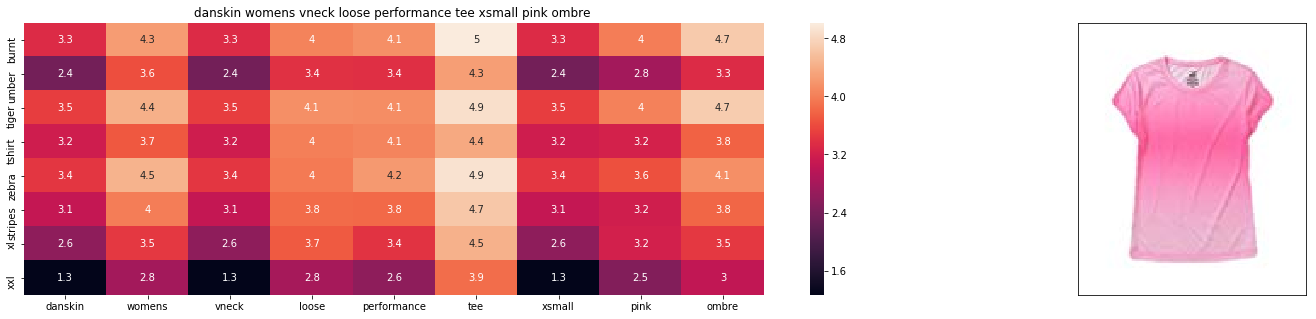

ASIN : B01F7PHXY8
Brand : Danskin Now
Product Title : danskin womens vneck loose performance tee xsmall pink ombre 
euclidean distance from the given image : 37.605684171242714


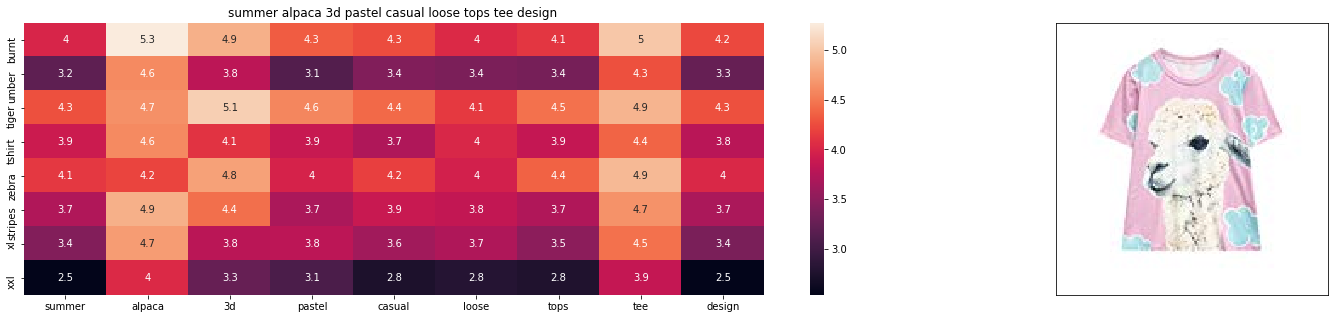

ASIN : B01I80A93G
Brand : Namnoi Clothing Store
Product Title : summer alpaca 3d pastel casual loose tops tee design 
euclidean distance from the given image : 37.63693763495664


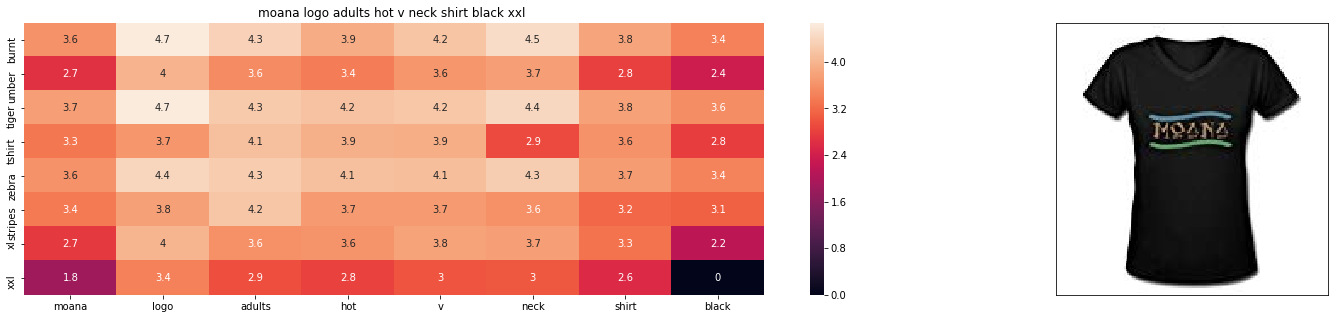

ASIN : B01LX6H43D
Brand : BOBOB
Product Title : moana logo adults hot v neck shirt black xxl 
euclidean distance from the given image : 37.65043856136396


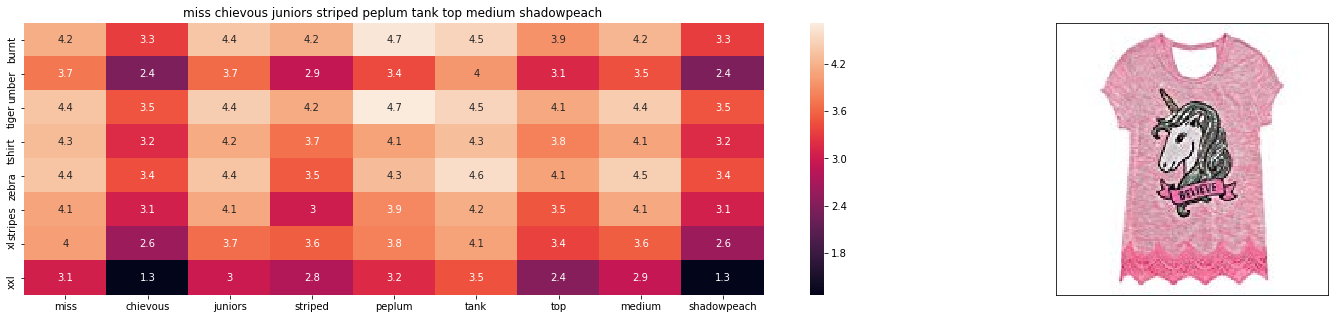

ASIN : B0177DM70S
Brand : MISS CHIEVOUS/AROUND THE WORLD APP
Product Title : miss chievous juniors striped peplum tank top medium shadowpeach 
euclidean distance from the given image : 37.66758088373217


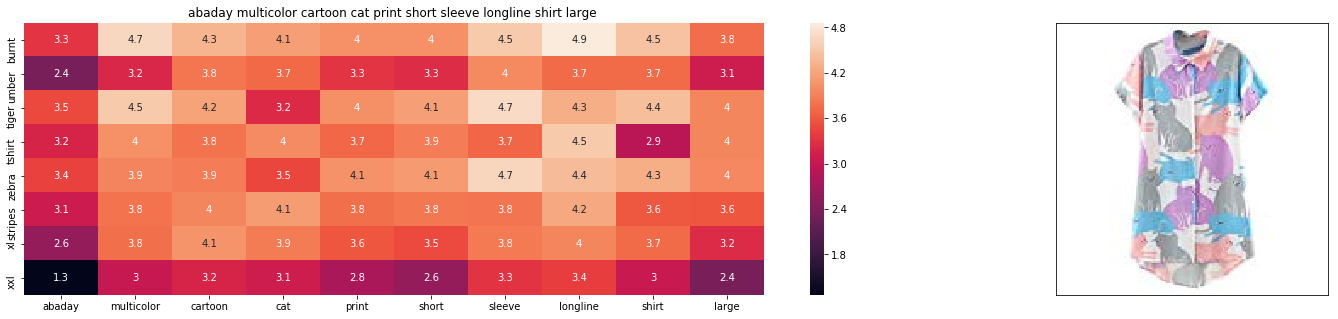

ASIN : B01CR57YY0
Brand : ABADAY
Product Title : abaday multicolor cartoon cat print short sleeve longline shirt large 
euclidean distance from the given image : 37.69579524327154


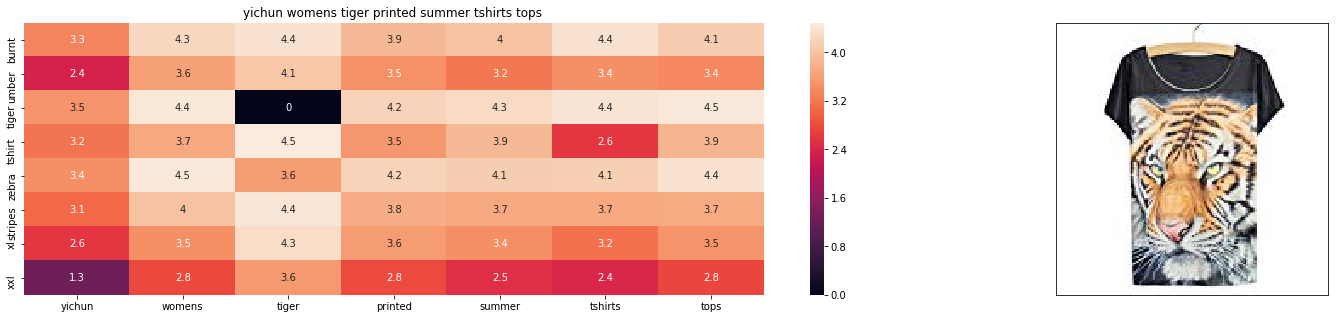

ASIN : B010NN9RXO
Brand : YICHUN
Product Title : yichun womens tiger printed summer tshirts tops 
euclidean distance from the given image : 37.7880964897007


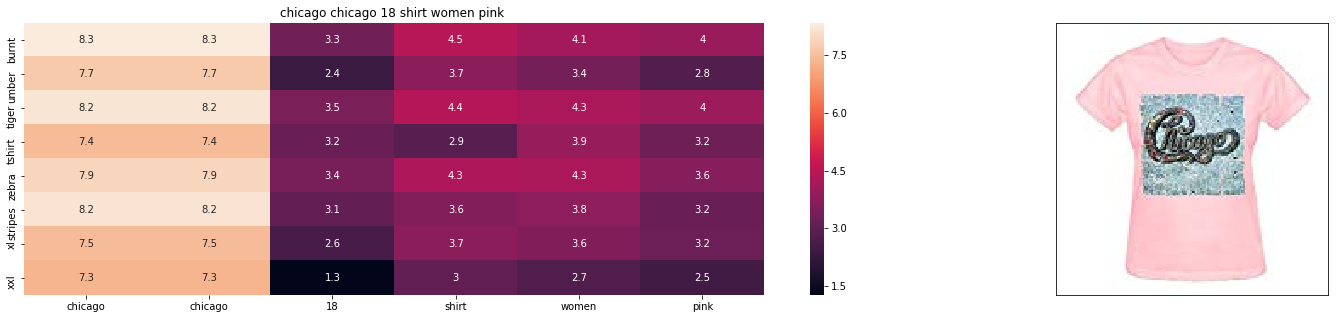

ASIN : B01GXAZTRY
Brand : Tony Arden
Product Title : chicago chicago 18 shirt women pink 
euclidean distance from the given image : 37.78851541375226


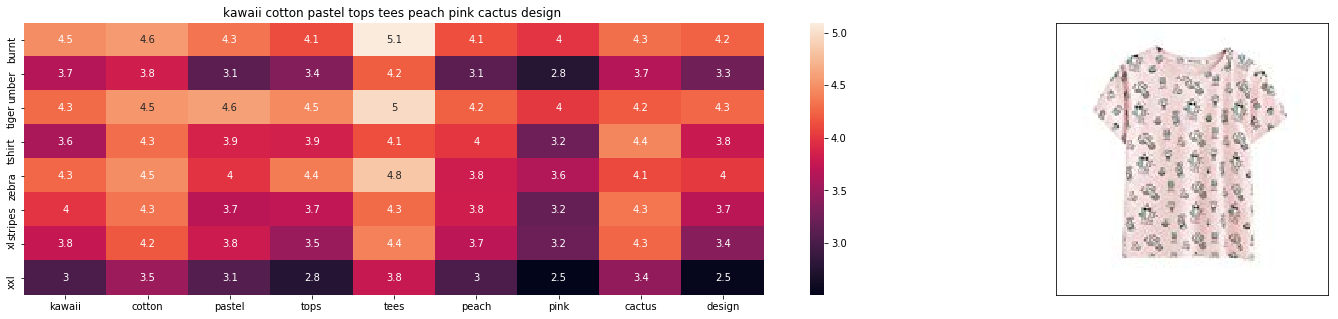

ASIN : B071WYLBZS
Brand : Namnoi Clothing Store
Product Title : kawaii cotton pastel tops tees peach pink cactus design 
euclidean distance from the given image : 37.82438833733044


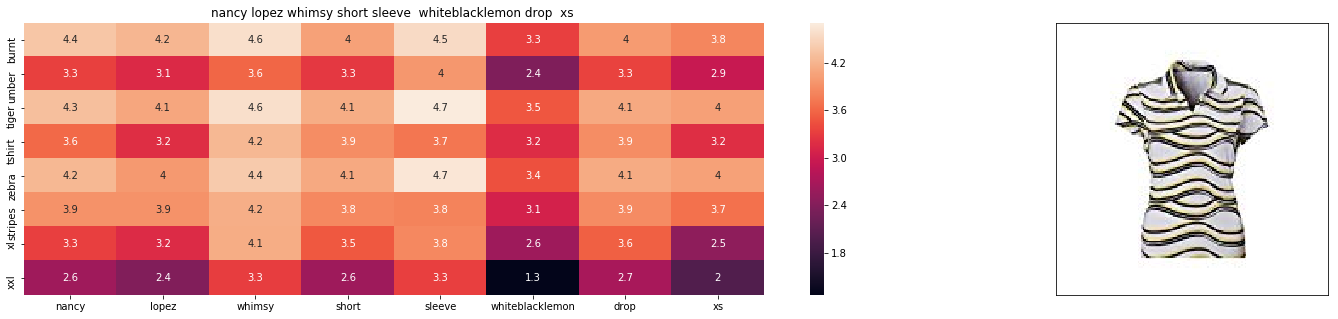

ASIN : B01MPX6IDX
Brand : Nancy Lopez
Product Title : nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
euclidean distance from the given image : 37.925000646706714


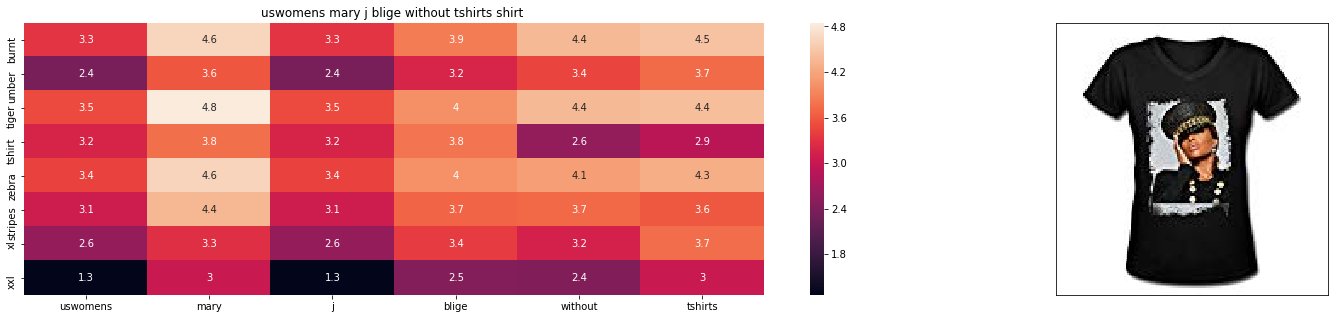

ASIN : B01M0XXFKK
Brand : South Dakota A.
Product Title : uswomens mary j blige without tshirts shirt 
euclidean distance from the given image : 37.94614018193559


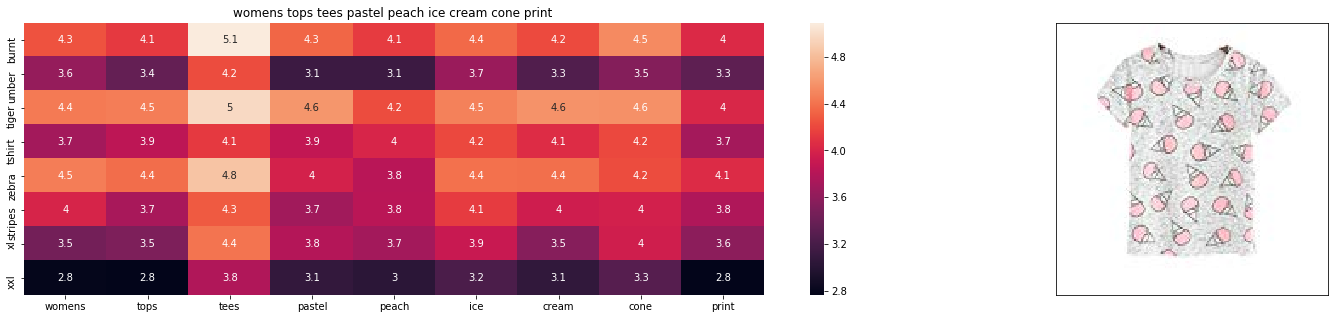

ASIN : B0734GRKZL
Brand : Namnoi Clothing Store
Product Title : womens tops tees pastel peach ice cream cone print 
euclidean distance from the given image : 37.950247780758886


In [53]:
#more weights to image features
def idf_model(doc_id,w1,w2,w3,w4,num_results):
    # doc_id: apparel's id in given corpus
    doc_id = asins.index(df_asins[doc_id])
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    idf_w2v_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    brand_features_dist = pairwise_distances(brand_features, brand_features[doc_id].reshape(1,-1))
    bottleneck_features_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    color_features_dist = pairwise_distances(color_features, color_features[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * brand_features_dist+w3*color_features_dist+w4*bottleneck_features_dist)/float(w1 + w2+w3+w4)
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(len(indices)):
        #get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        #display(Image(url=data['medium_image_url'].loc[df_indices[i]], embed=True))
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('Product Title :',data['title'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,1,1,1,10,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

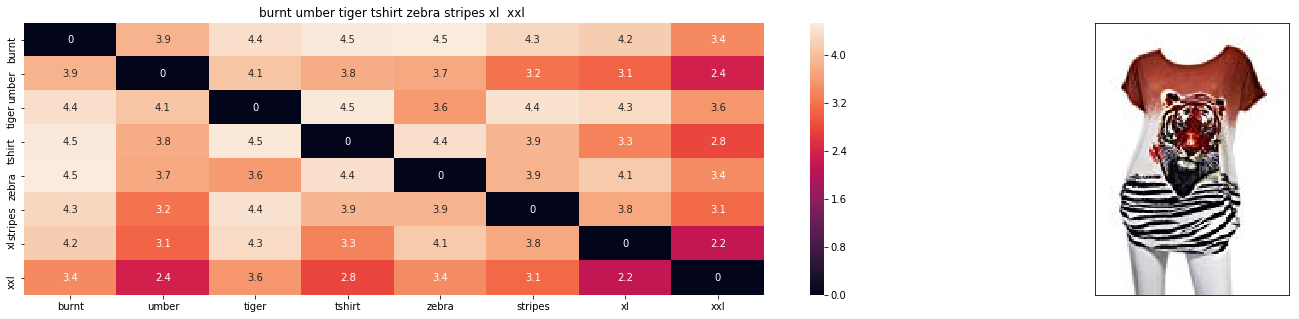

ASIN : B00JXQB5FQ
Brand : Si Row
Product Title : burnt umber tiger tshirt zebra stripes xl  xxl 
euclidean distance from the given image : 0.0004290696414350306


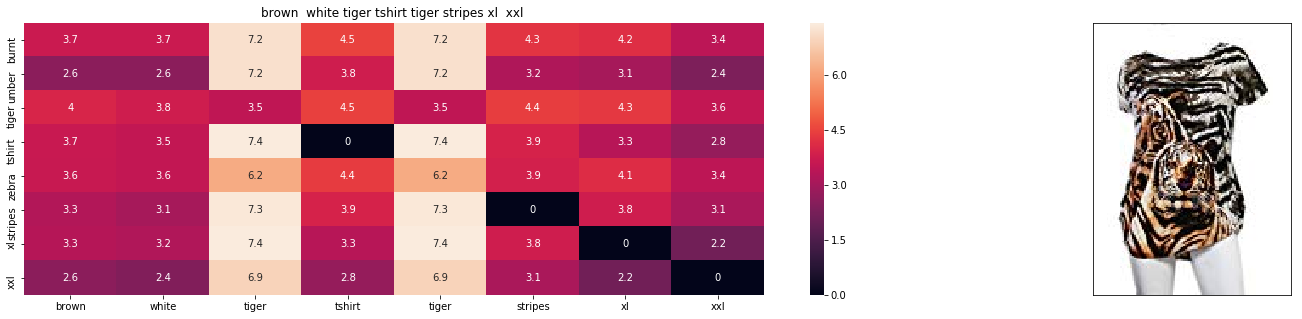

ASIN : B00JXQCWTO
Brand : Si Row
Product Title : brown  white tiger tshirt tiger stripes xl  xxl 
euclidean distance from the given image : 0.4509678456994271


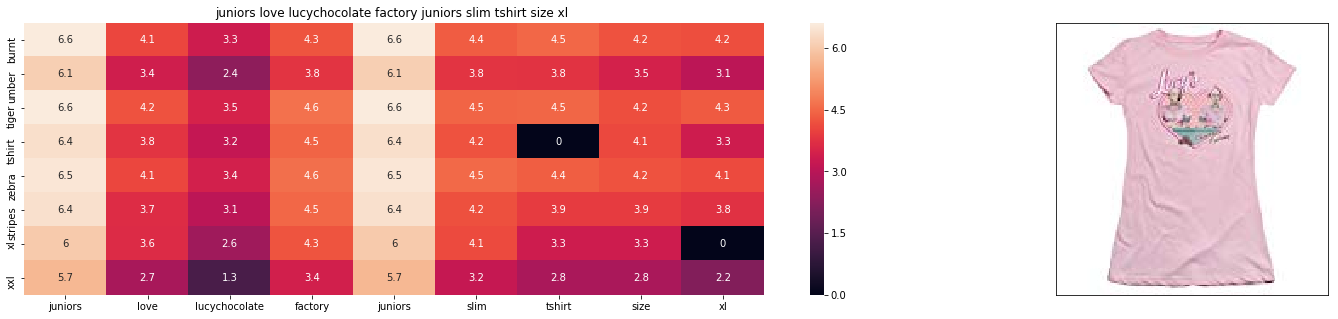

ASIN : B00IAA5LLA
Brand : I Love Lucy
Product Title : juniors love lucychocolate factory juniors slim tshirt size xl 
euclidean distance from the given image : 0.5490246502888577


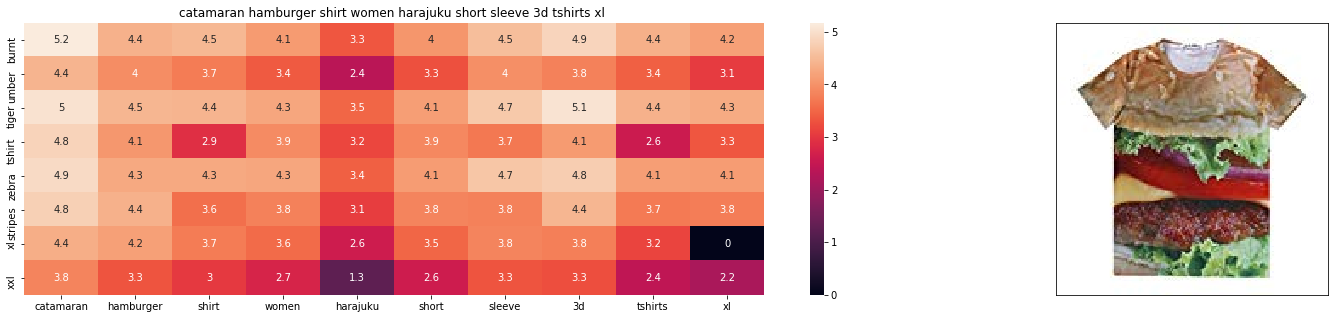

ASIN : B01CR325BE
Brand : Catamaran
Product Title : catamaran hamburger shirt women harajuku short sleeve 3d tshirts xl 
euclidean distance from the given image : 0.5542015789328023


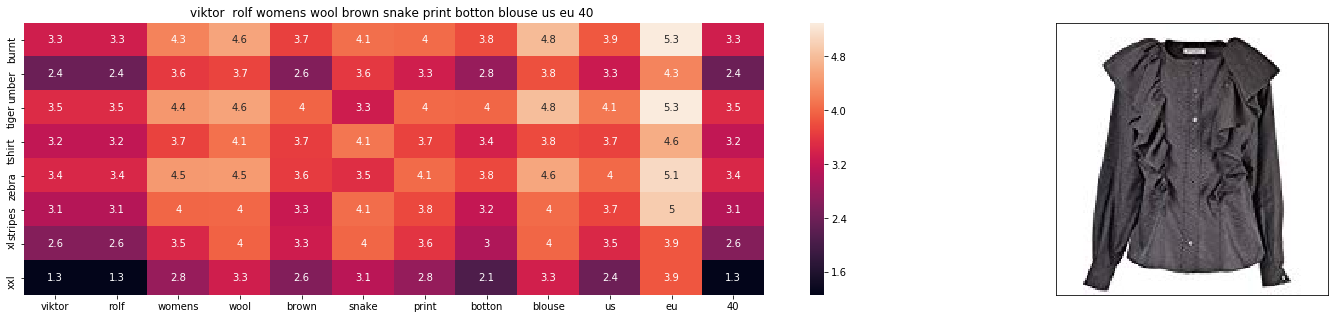

ASIN : B00LEHNVZ4
Brand : Viktor & Rolf
Product Title : viktor  rolf womens wool brown snake print botton blouse us eu 40 
euclidean distance from the given image : 0.5546943371147752


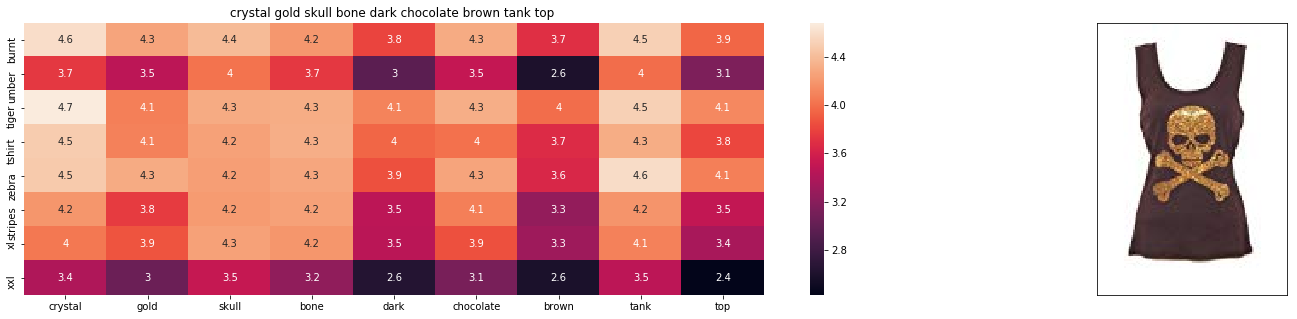

ASIN : B004YR55O6
Brand : stonepowerss
Product Title : crystal gold skull bone dark chocolate brown tank top 
euclidean distance from the given image : 0.5634192727106058


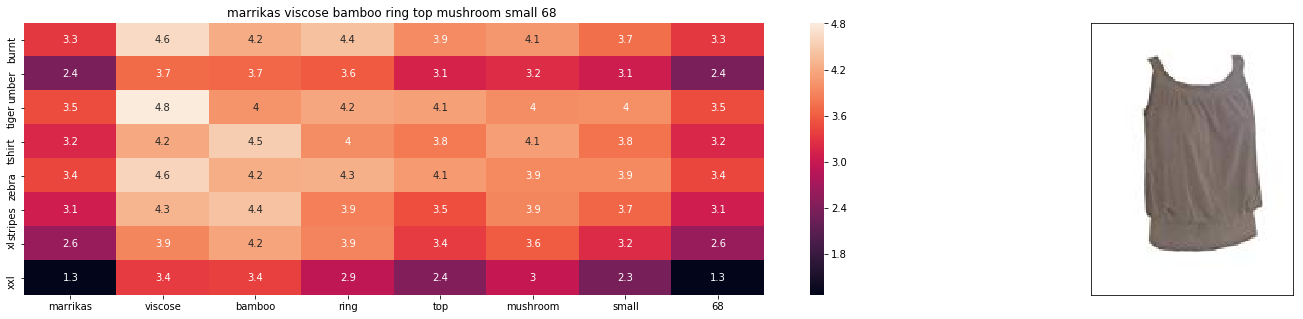

ASIN : B003SPYNAM
Brand : Marrikas
Product Title : marrikas viscose bamboo ring top mushroom small 68 
euclidean distance from the given image : 0.5687876479843041


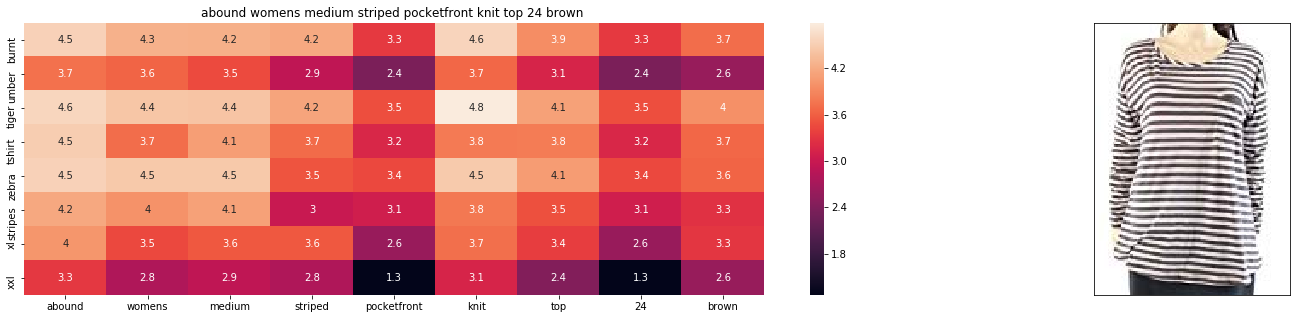

ASIN : B072M4ZF89
Brand : Abound
Product Title : abound womens medium striped pocketfront knit top 24 brown 
euclidean distance from the given image : 0.5715428001633894


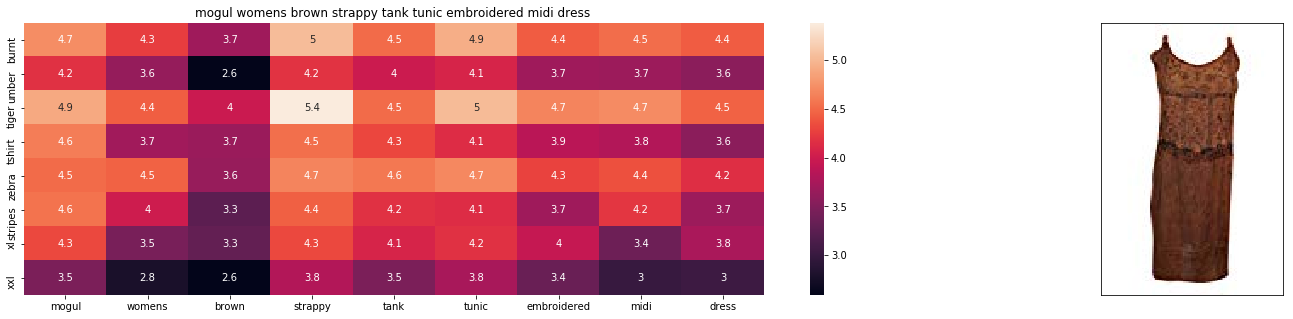

ASIN : B07191F766
Brand : Mogul Interior
Product Title : mogul womens brown strappy tank tunic embroidered midi dress 
euclidean distance from the given image : 0.5755026512191149


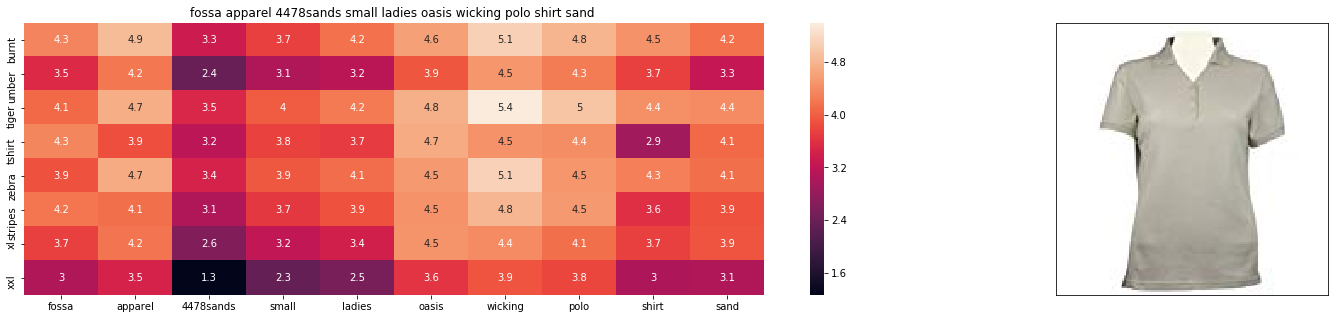

ASIN : B00DTWJR2I
Brand : None
Product Title : fossa apparel 4478sands small ladies oasis wicking polo shirt sand 
euclidean distance from the given image : 0.5806654328386694


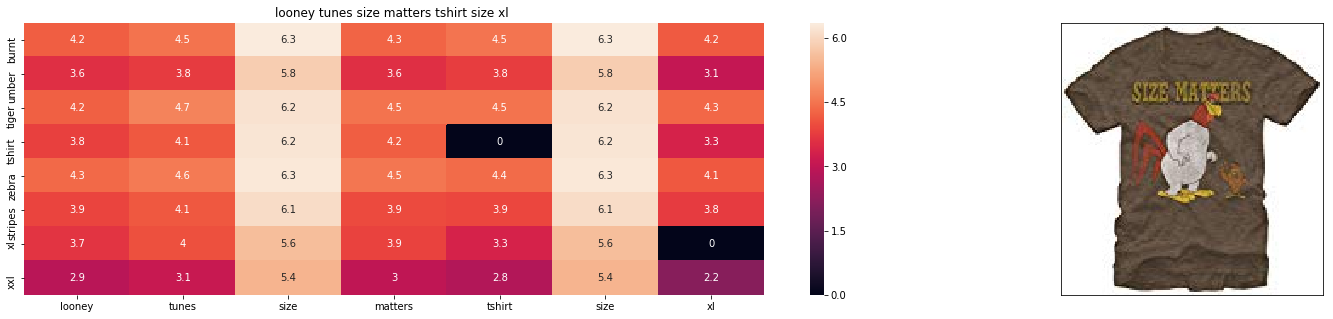

ASIN : B01BQKAQAG
Brand : Foghorn Leghorn
Product Title : looney tunes size matters tshirt size xl 
euclidean distance from the given image : 0.5818014286950577


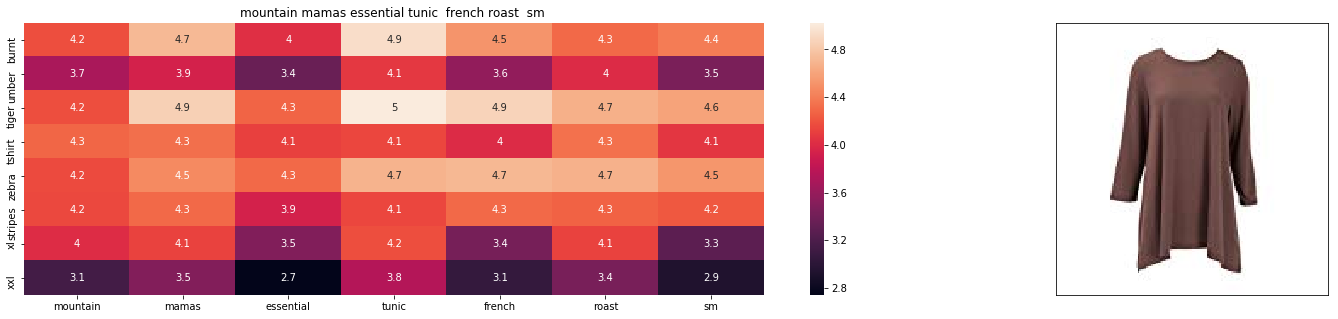

ASIN : B074JH922V
Brand : Mountain Mama's
Product Title : mountain mamas essential tunic  french roast  sm 
euclidean distance from the given image : 0.5880560771722959


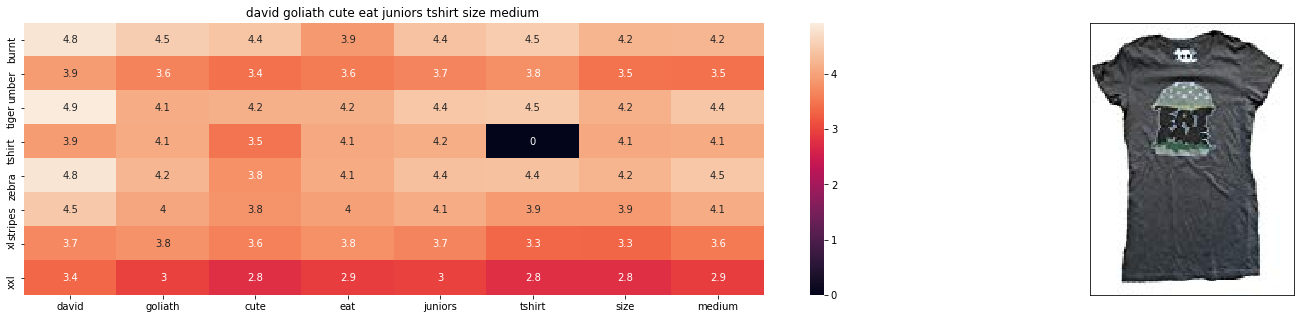

ASIN : B01M4JE4X4
Brand : David & Goliath
Product Title : david goliath cute eat juniors tshirt size medium 
euclidean distance from the given image : 0.5890250727828856


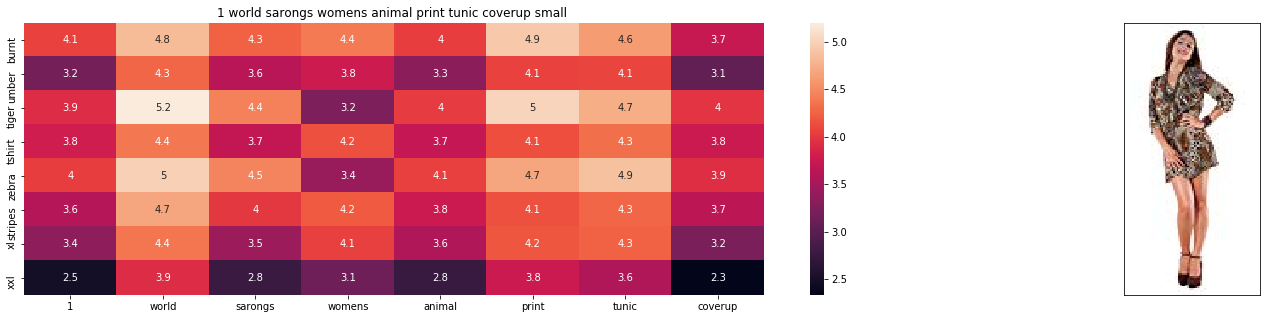

ASIN : B017YBAI9A
Brand : La Fleva
Product Title : 1 world sarongs womens animal print tunic coverup small 
euclidean distance from the given image : 0.5909103097267521


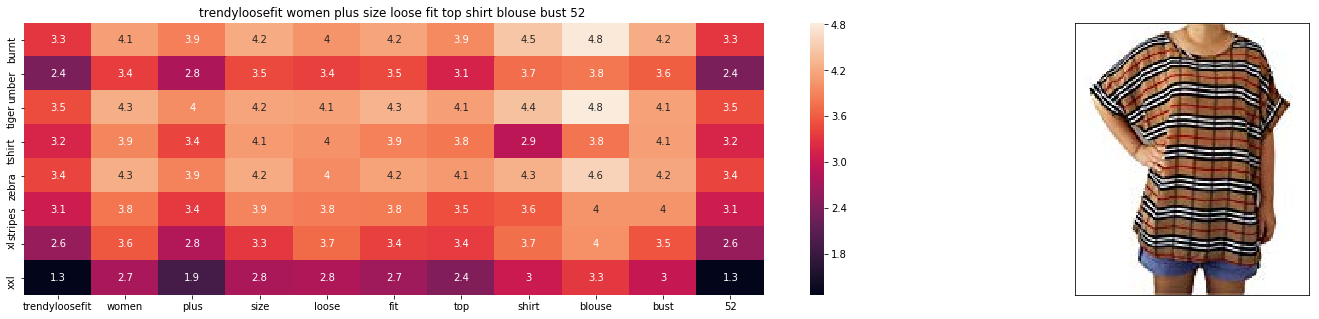

ASIN : B019EGEV9Q
Brand : Trendyloosefit
Product Title : trendyloosefit women plus size loose fit top shirt blouse bust 52 
euclidean distance from the given image : 0.5915793236132451


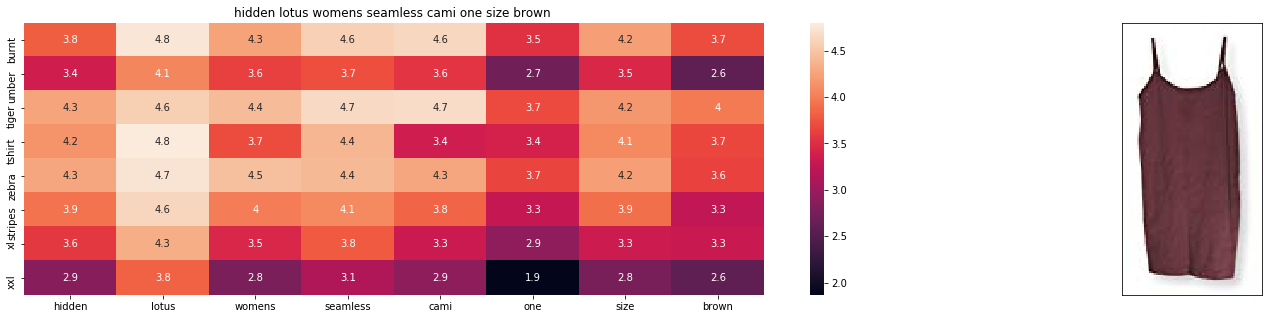

ASIN : B01DAW0PBS
Brand : Hidden Lotus
Product Title : hidden lotus womens seamless cami one size brown 
euclidean distance from the given image : 0.5964839898266838


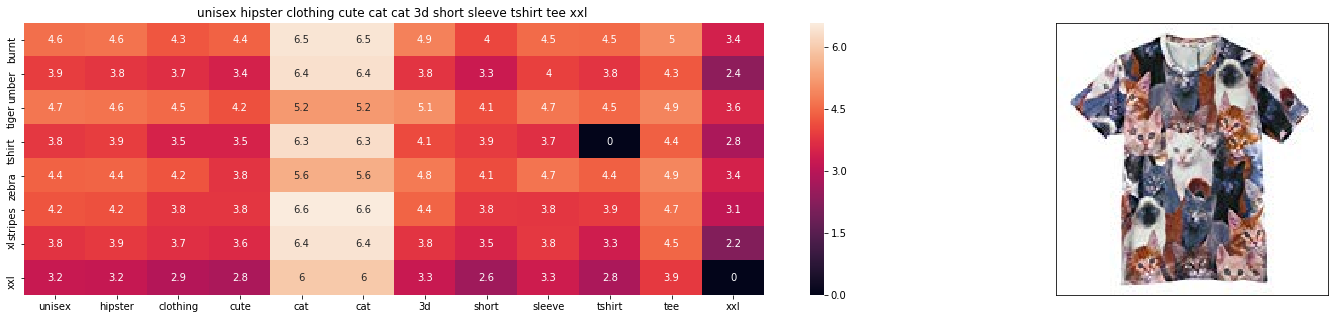

ASIN : B00OM4EH4K
Brand : Moji
Product Title : unisex hipster clothing cute cat cat 3d short sleeve tshirt tee xxl 
euclidean distance from the given image : 0.5967339275761403


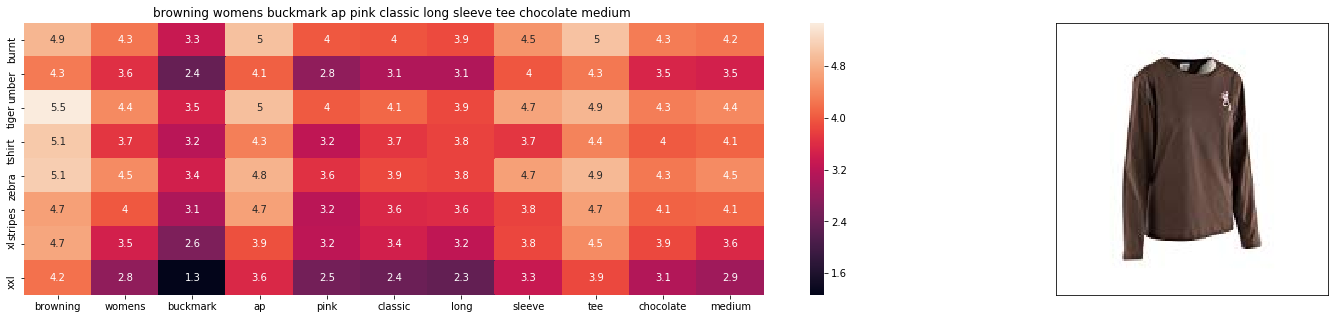

ASIN : B00NQFH7MA
Brand : Browning
Product Title : browning womens buckmark ap pink classic long sleeve tee chocolate medium 
euclidean distance from the given image : 0.5968236434919806


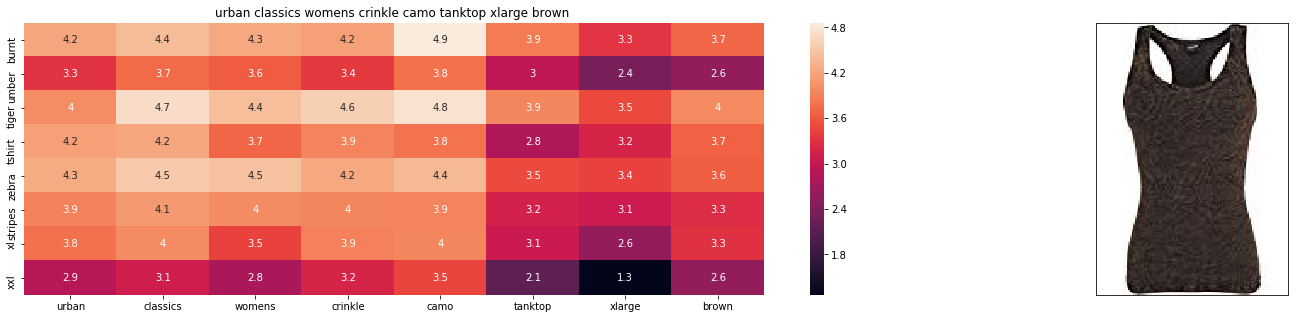

ASIN : B00BG0UJ40
Brand : CamoOutdoor
Product Title : urban classics womens crinkle camo tanktop xlarge brown 
euclidean distance from the given image : 0.5977180527955337


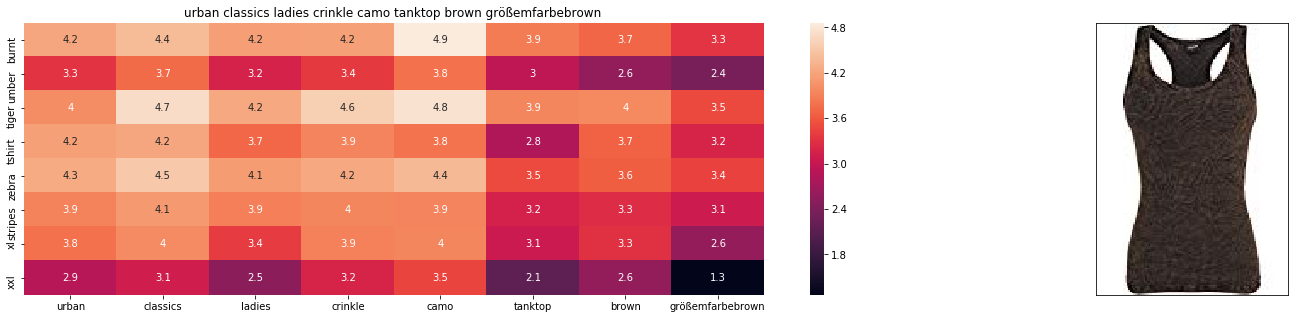

ASIN : B00BG0UIHI
Brand : CamoOutdoor
Product Title : urban classics ladies crinkle camo tanktop brown größemfarbebrown 
euclidean distance from the given image : 0.5977180527955337


In [62]:
#more weights to color features
def idf_model(doc_id,w1,w2,w3,w4,num_results):
    # doc_id: apparel's id in given corpus
    doc_id = asins.index(df_asins[doc_id])
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    idf_w2v_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    brand_features_dist = pairwise_distances(brand_features, brand_features[doc_id].reshape(1,-1))
    bottleneck_features_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    color_features_dist = pairwise_distances(color_features, color_features[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * brand_features_dist+w3*color_features_dist+w4*bottleneck_features_dist)/float(w1 + w2+w3+w4)
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(len(indices)):
        #get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        #display(Image(url=data['medium_image_url'].loc[df_indices[i]], embed=True))
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('Product Title :',data['title'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,1,1,100,1,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

Most of the shirts have same color i.e brown/black

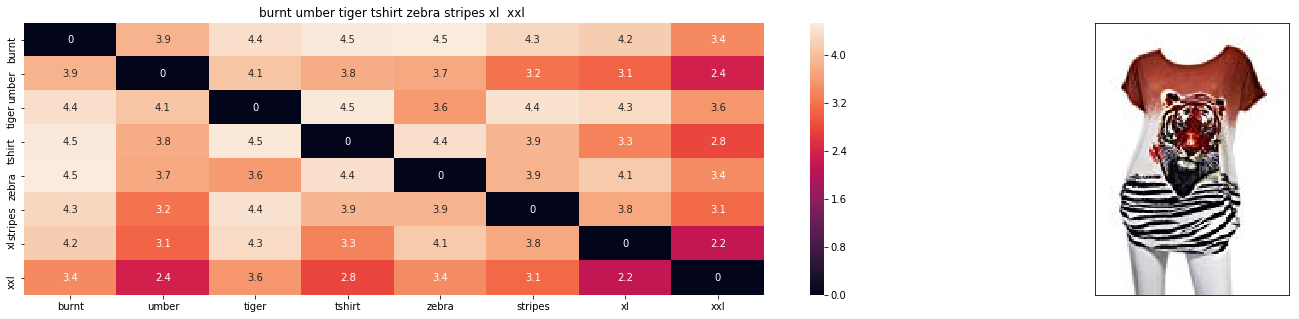

ASIN : B00JXQB5FQ
Brand : Si Row
Product Title : burnt umber tiger tshirt zebra stripes xl  xxl 
euclidean distance from the given image : 0.011048543266952038


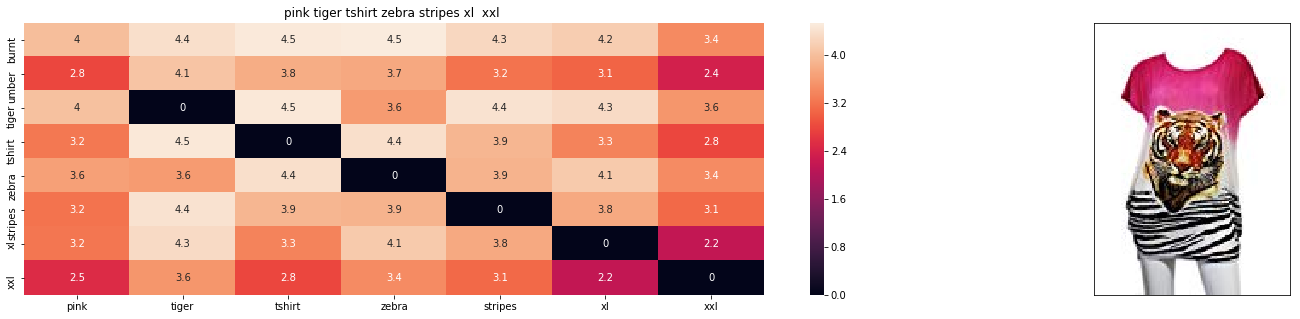

ASIN : B00JXQASS6
Brand : Si Row
Product Title : pink tiger tshirt zebra stripes xl  xxl 
euclidean distance from the given image : 8.299080206865376


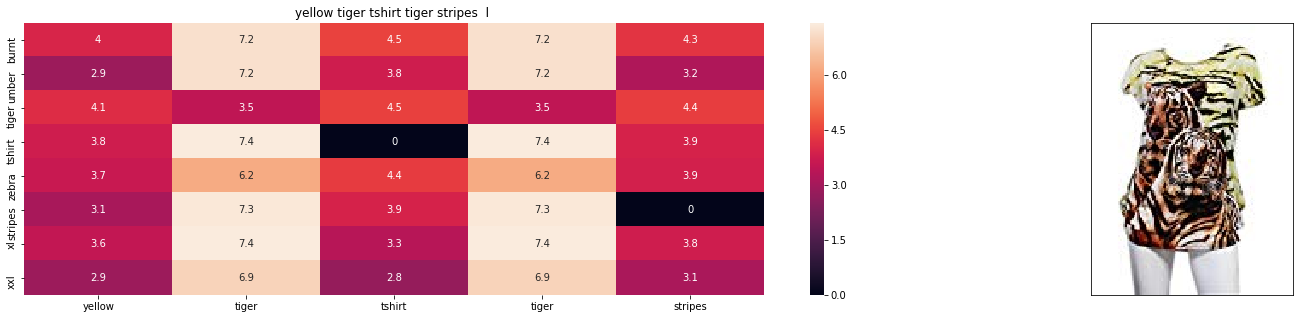

ASIN : B00JXQCUIC
Brand : Si Row
Product Title : yellow tiger tshirt tiger stripes  l 
euclidean distance from the given image : 11.330269271643113


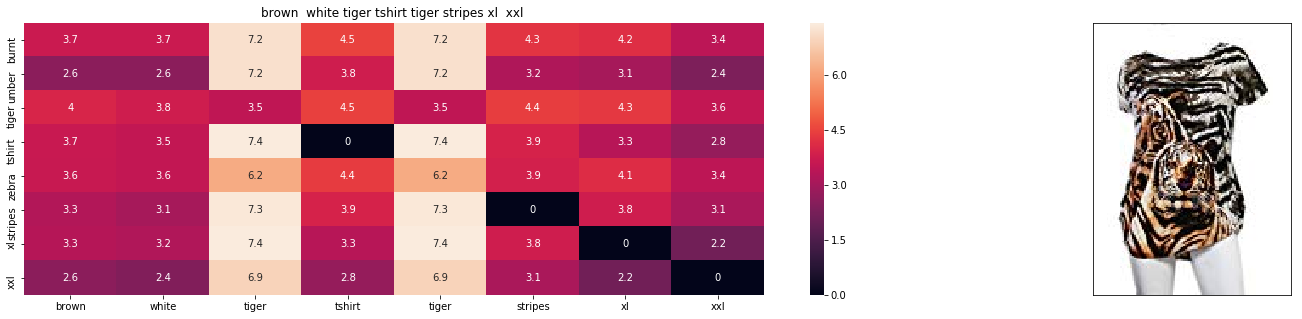

ASIN : B00JXQCWTO
Brand : Si Row
Product Title : brown  white tiger tshirt tiger stripes xl  xxl 
euclidean distance from the given image : 11.612422026760248


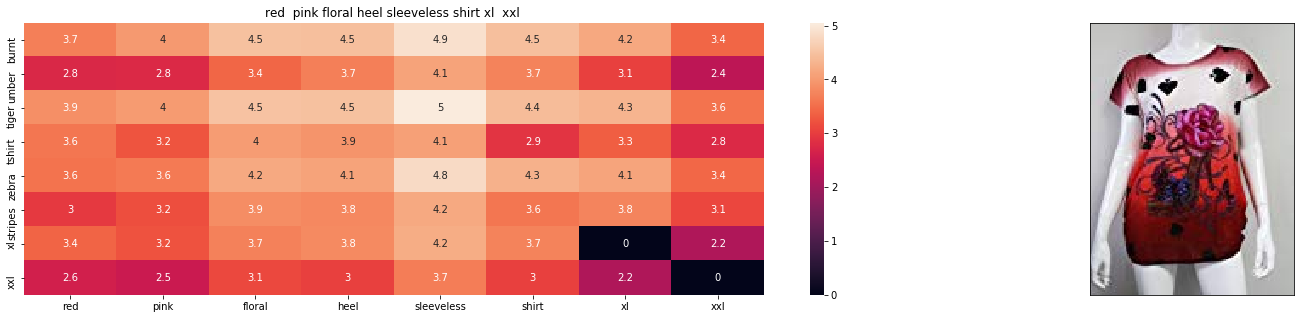

ASIN : B00JV63QQE
Brand : Si Row
Product Title : red  pink floral heel sleeveless shirt xl  xxl 
euclidean distance from the given image : 13.261941007512478


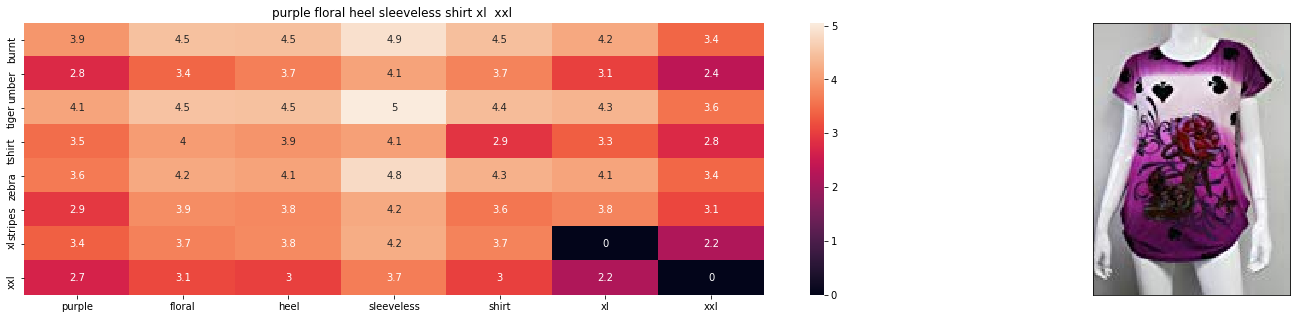

ASIN : B00JV63VC8
Brand : Si Row
Product Title : purple floral heel sleeveless shirt xl  xxl 
euclidean distance from the given image : 13.446774377000484


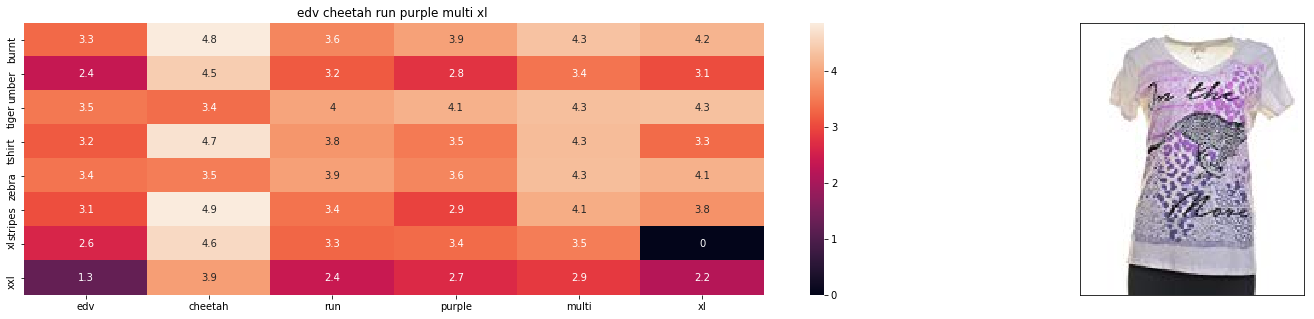

ASIN : B01CUPYBM0
Brand : Styleco
Product Title : edv cheetah run purple multi xl 
euclidean distance from the given image : 13.664208203118076


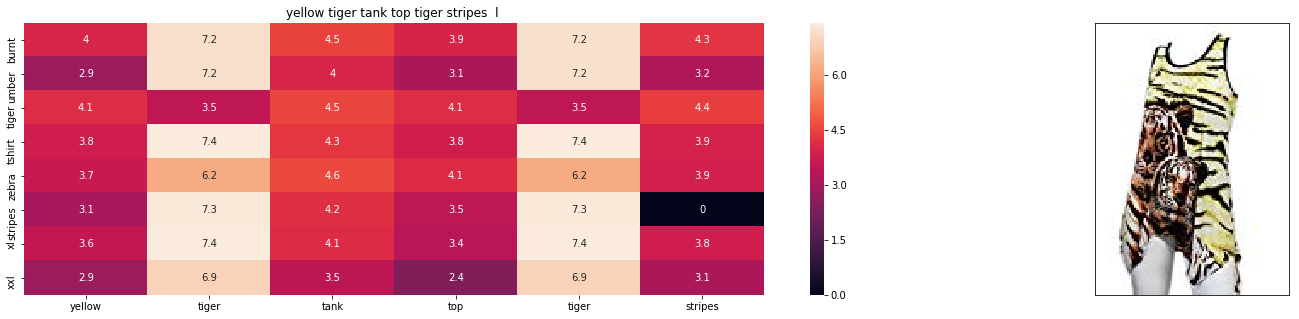

ASIN : B00JXQAUWA
Brand : Si Row
Product Title : yellow tiger tank top tiger stripes  l 
euclidean distance from the given image : 13.69167682174865


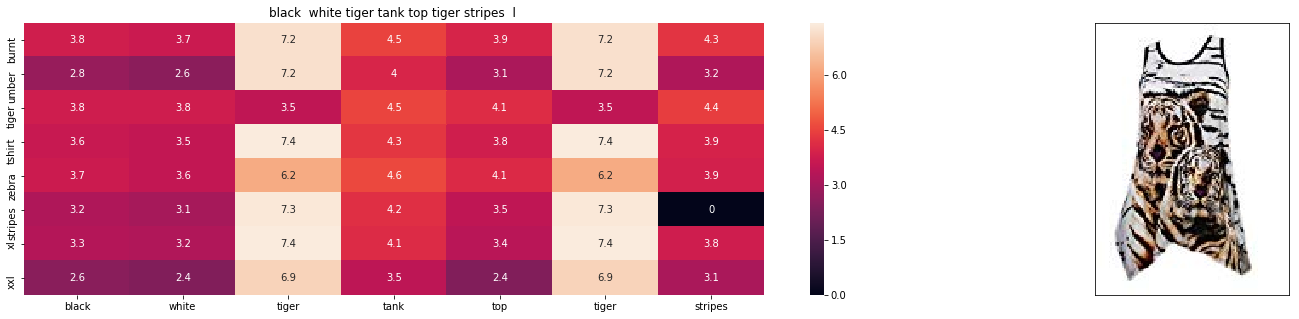

ASIN : B00JXQAO94
Brand : Si Row
Product Title : black  white tiger tank top tiger stripes  l 
euclidean distance from the given image : 13.759021653306636


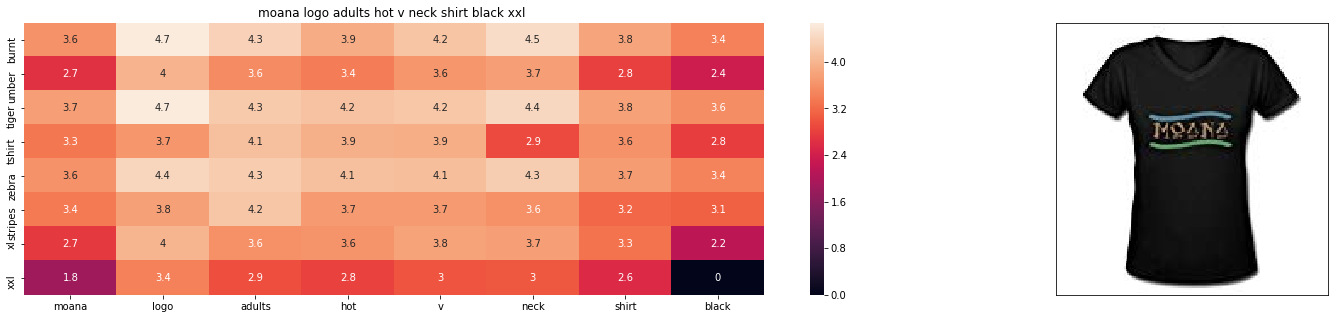

ASIN : B01LX6H43D
Brand : BOBOB
Product Title : moana logo adults hot v neck shirt black xxl 
euclidean distance from the given image : 13.786175118439232


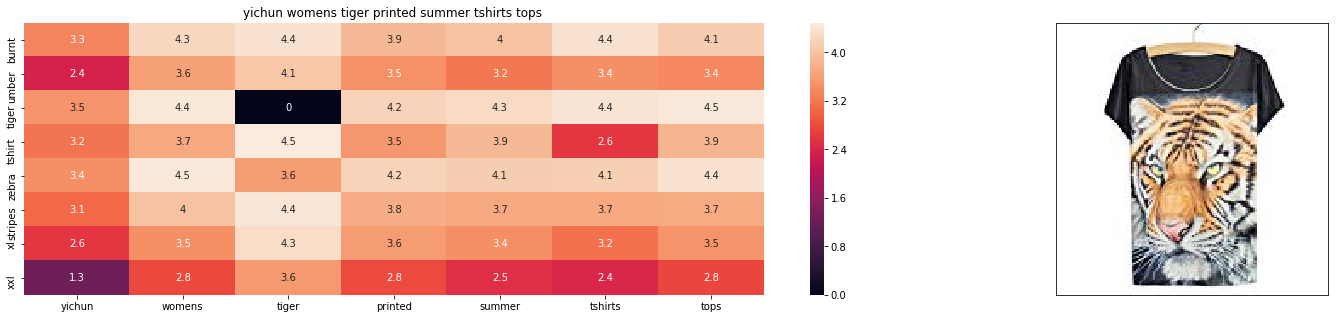

ASIN : B010NN9RXO
Brand : YICHUN
Product Title : yichun womens tiger printed summer tshirts tops 
euclidean distance from the given image : 13.800290070103932


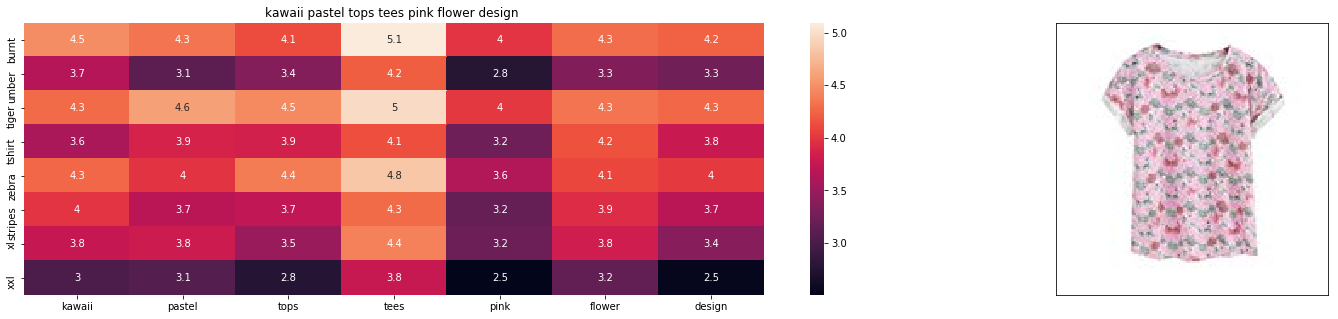

ASIN : B071FCWD97
Brand : Namnoi Clothing Store
Product Title : kawaii pastel tops tees pink flower design 
euclidean distance from the given image : 13.805903317548026


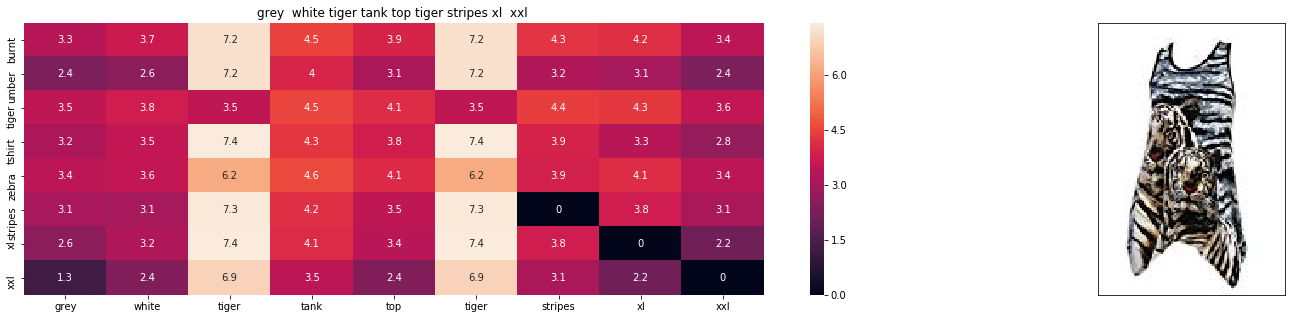

ASIN : B00JXQAFZ2
Brand : Si Row
Product Title : grey  white tiger tank top tiger stripes xl  xxl 
euclidean distance from the given image : 13.873175239653332


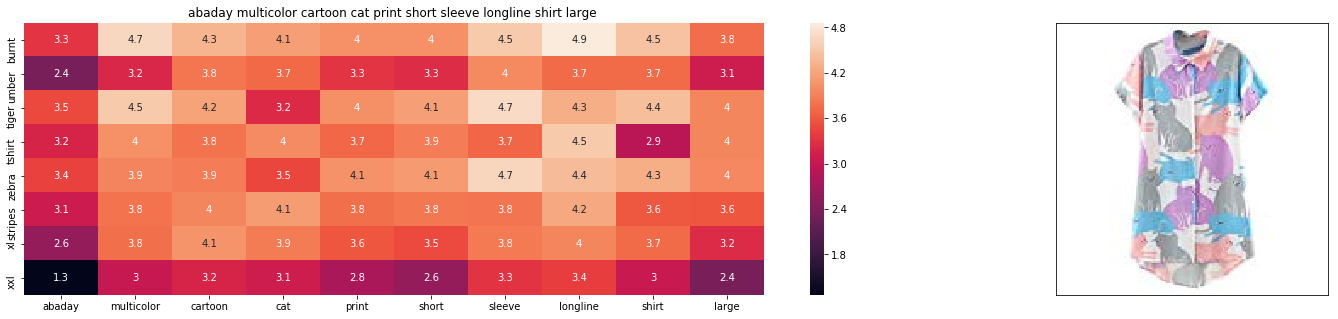

ASIN : B01CR57YY0
Brand : ABADAY
Product Title : abaday multicolor cartoon cat print short sleeve longline shirt large 
euclidean distance from the given image : 13.913637282636897


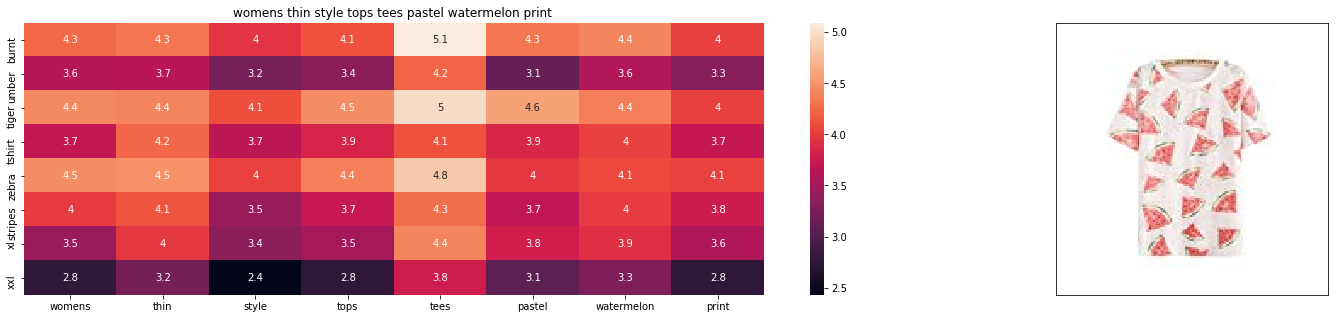

ASIN : B01JUNHBRM
Brand : Namnoi Clothing Store
Product Title : womens thin style tops tees pastel watermelon print 
euclidean distance from the given image : 13.921627550881425


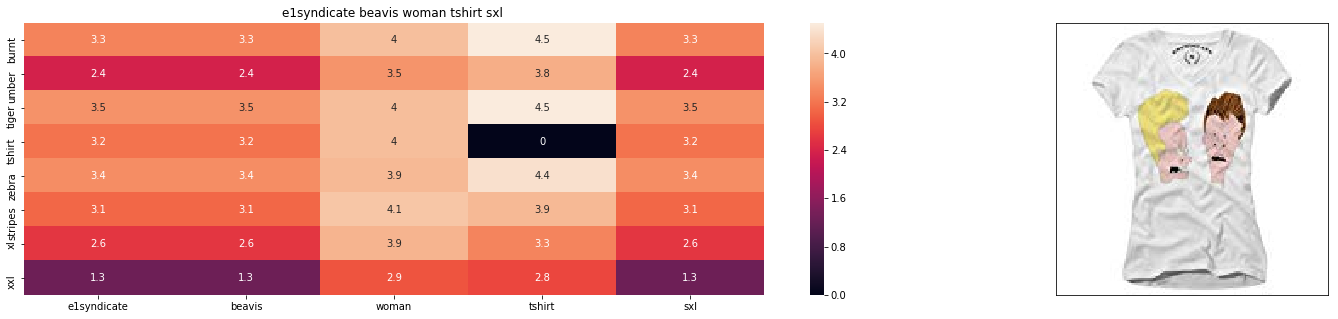

ASIN : B01HZX2GQ0
Brand : E1SYNDICATE
Product Title : e1syndicate beavis woman tshirt sxl 
euclidean distance from the given image : 13.924719444310183


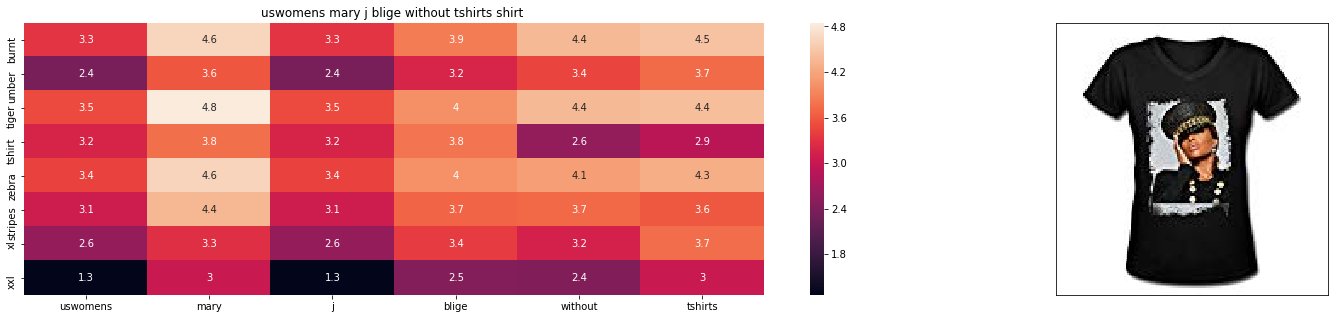

ASIN : B01M0XXFKK
Brand : South Dakota A.
Product Title : uswomens mary j blige without tshirts shirt 
euclidean distance from the given image : 13.94256652268715


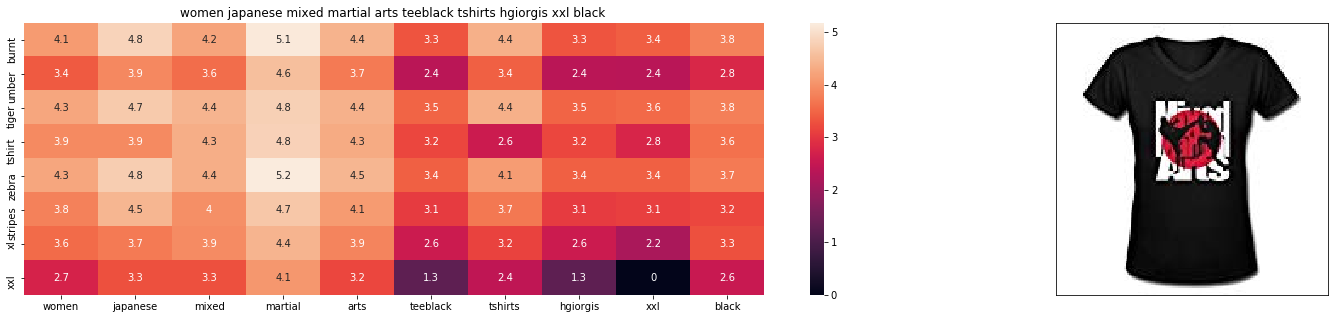

ASIN : B01JQ096HW
Brand : Constanza
Product Title : women japanese mixed martial arts teeblack tshirts hgiorgis xxl black 
euclidean distance from the given image : 13.94262058925063


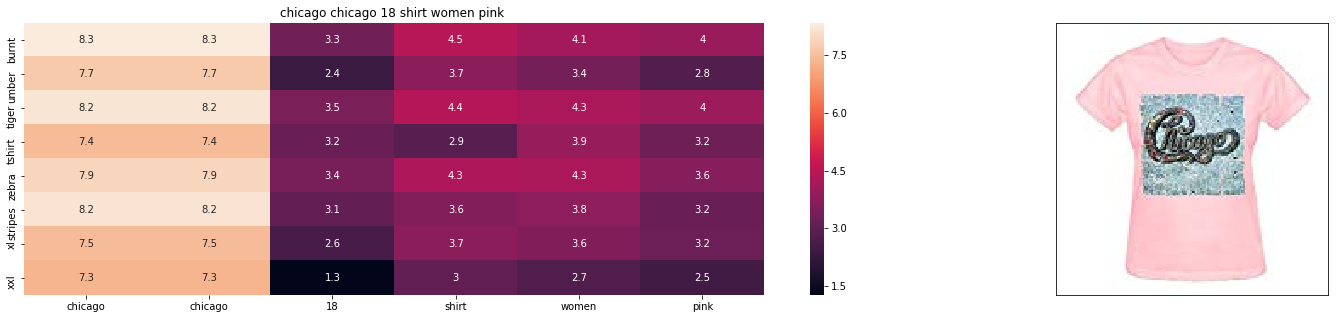

ASIN : B01GXAZTRY
Brand : Tony Arden
Product Title : chicago chicago 18 shirt women pink 
euclidean distance from the given image : 13.949465370268566


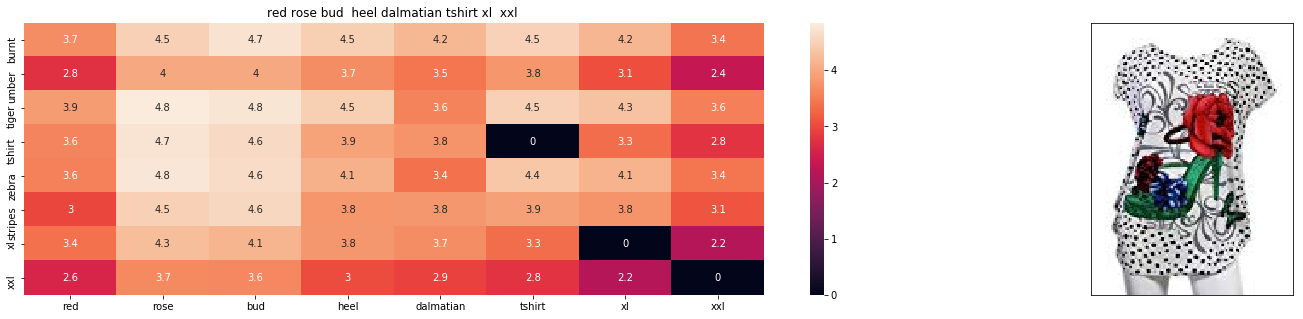

ASIN : B00JXQABB0
Brand : Si Row
Product Title : red rose bud  heel dalmatian tshirt xl  xxl 
euclidean distance from the given image : 13.95138427261535


In [54]:
#equal weights to all features
def idf_model(doc_id,w1,w2,w3,w4,num_results):
    # doc_id: apparel's id in given corpus
    doc_id = asins.index(df_asins[doc_id])
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    idf_w2v_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    brand_features_dist = pairwise_distances(brand_features, brand_features[doc_id].reshape(1,-1))
    bottleneck_features_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    color_features_dist = pairwise_distances(color_features, color_features[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * brand_features_dist+w3*color_features_dist+w4*bottleneck_features_dist)/float(w1 + w2+w3+w4)
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(len(indices)):
        #get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        #display(Image(url=data['medium_image_url'].loc[df_indices[i]], embed=True))
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('Product Title :',data['title'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,1,1,1,1,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

We get better recommendations when we give equal weights to all features

## Conclusion:
    

Objective:
To Recommend similar products to the user based on the product user views.


1. We get the data using amazon api. we have 180k rows and 19 features of which we use only 7 columns (asin, title, medium_image_url, price, product_type_name,brand,color).
<br>
2. We perform EDA on the dataset to get some insights about the data and we remove the duplicates and near duplicates and also we remove the rows containing null values to reduce the processing time. 
<br>
3. We reduce the 180k to only 16k rows, We preprocess the data and remove the stop words.
<br>
4. We vectorize the title using BoW, TFIDF, weighted w2v and TFIDF weighted w2v.
<br>
5. We then recommend the apparels using those features and find the similarity between the title vectors and recommend the products which have the lowest euclidean distance and visualize the similarity using heatmaps.
<br>
6. We then try weighted similarity giving weights to brand, type and color and we observe that if we give more weights to brand it recommends the products with same brands. 
<br>
7. We then use images as features converting the images into nd vectors using a vgg-16 pre trained model and convert images in batches and then get the similarity between the vectors and recommend product based on images.
<br>
8. We try to improve results by stacking image features, color, title, and brand features and see if we get better recommendations.
<br>
9. We also try giving weights to the features and observe that We get better recommendations when we use all the features stacked with equal weights.